<a href="https://colab.research.google.com/github/d22cs051/dlops-23/blob/main/assignment/D22CS051_Lab_Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build the following RNN architecture to classify names based on their language

## Downloading the dataset from the link

In [ ]:
from pathlib import Path
data_path = Path("./data.zip")
dataset_path = Path("./data")

if not data_path.is_file():
    print("[INFO] Downloading data.zip [~4.9MB]")
    !wget "https://drive.google.com/uc?export=download&id=1-MKwYI0j3oQ1dkj7hexDRrVQaAIX0L3u" -O data.zip
else:
    print("[INFO] data.zip already exists")

if not dataset_path.is_dir():
    print("[INFO] Unzipping data.zip")
    !unzip -q "./data.zip"
else:
    print("[INFO] data.zip already unzipped")

[INFO] data.zip already exists
[INFO] data.zip already unzipped


## Procesing data

### setting all vaild chars in name

In [ ]:
import string
ALL_LETTERS = string.ascii_letters + " .,;'"
ALL_LETTERS

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

### function to convert Unicode to ASCII

In [ ]:
import unicodedata
def unicode_to_ascii(s:str):
    '''
    desc: Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/questions/2365411/convert-unicode-to-ascii-without-errors-in-python
    args: s: unicode string
    return: ascii string
    '''
    return unicodedata.normalize('NFD',s).encode('ascii', 'ignore').decode()

In [ ]:
print(unicode_to_ascii(u'aあä  aあä'))

aa  aa


### function to load data in '''dict[str:[List]]'''

In [ ]:
from pathlib import Path

def load_data():
    '''
    desc: loads data from data/names/*.txt
    
    data_dict = {
        'language1': ['name1', 'name2', ...],
    }
    classes = ['language1', 'language2', ...]
    
    returns: data_dict:dict, classes:List
    '''
    data_dict = {}
    classes = []

    data_path = Path("./data/names")

    for file in data_path.glob("*.txt"):
        key = file.stem
        classes.append(key)
        with open(file, "r") as f:
            data_dict[key] = [unicode_to_ascii(line) for line in f.read().splitlines()]
    return data_dict, classes

### functions for one hot encoding

In [ ]:
import torch
def ohe_letter(letter:str) -> torch.Tensor:
    '''
    desc: one hot encoding of a letter
    args:
        letter (str): a single letter
    returns:
        ohe (torch.Tensor): one hot encoded letter
    '''
    letter_idx = ALL_LETTERS.find(letter)
    ohe = [0] * len(ALL_LETTERS)
    ohe[letter_idx] = 1
    # print(ohe)
    return torch.Tensor(ohe)

In [ ]:
import torch
def line_to_tensor(line:str) -> torch.Tensor:
    '''
    desc: converts a line to a tensor
    args:
        line (str): a line of text
    returns:
        tensor (torch.Tensor): tensor of shape (line_length, 1, len(ALL_LETTERS))
    '''
    tensor = torch.zeros(len(line), 1, len(ALL_LETTERS))
    for idx, letter in enumerate(line):
        tensor[idx][0] = ohe_letter(letter)
    return tensor

In [ ]:
print(ohe_letter('B')) # [1, 57]
print(line_to_tensor('Bikash').size()) # [6, 1, 57]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.])
torch.Size([6, 1, 57])


### making train val test split

In [ ]:
from sklearn.model_selection import train_test_split
def get_train_val_test_splits(data_dict:dict, classes:list, test_size:float=0.1, val_size:float=0.1, random_state:int=42):
    '''
    desc: splits data into train, val and test sets
    args:
        data_dict (dict): dictionary of data
        classes (list): list of classes
        test_size (float): test set size
        val_size (float): validation set size
        random_state (int): random state
    returns:
        train_data (dict): train data
        val_data (dict): validation data
        test_data (dict): test data
    '''
    data = [(words, k) for k, v in data_dict.items() for words in v]
    train_data, test_data = train_test_split(data, test_size=test_size, random_state=random_state)
    train_data, val_data = train_test_split(train_data, test_size=val_size, random_state=random_state)
    train_data_dict = {}
    val_data_dict = {}
    test_data_dict = {}
    for i in train_data:
        if i[1] in train_data_dict:
            train_data_dict[i[1]].append(i[0])
        else:
            train_data_dict[i[1]] = [i[0]]
    for i in test_data:
        if i[1] in test_data_dict:
            test_data_dict[i[1]].append(i[0])
        else:
            test_data_dict[i[1]] = [i[0]]
    for i in val_data:
        if i[1] in val_data_dict:
            val_data_dict[i[1]].append(i[0])
        else:
            val_data_dict[i[1]] = [i[0]]
    return train_data_dict, val_data_dict, test_data_dict

In [ ]:
data = load_data()
CLASSES = data[1]
train_data, val_data, test_data = get_train_val_test_splits(data[0],data[1])

## Checking GPUs

In [ ]:
!nvidia-smi

Sun Mar  5 23:09:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.78.01    Driver Version: 525.78.01    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   47C    P8    34W / 350W |    515MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Importing Required Libraries

In [ ]:
import torch
import torchaudio

# pytorch libs
import torch
from torch import nn
import torchaudio

# matplot libs
import matplotlib.pyplot as plt

# numpy
import numpy as np

# torch metrics
try:
  import torchmetrics
except:
  !pip3 -q install torchmetrics
import torchmetrics
from torchmetrics.classification import Accuracy

try:
  import torchinfo
except:
  !pip3 -q install torchinfo
finally:
  from torchinfo import summary

try:
  import torchattacks
except:
  !pip3 -q install torchattacks
finally:
  import torchattacks


## Device setup code

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

## Model Class Defination

In [ ]:
import torch.nn as nn

# source: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

class RNNBasic(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

## Training the network

### model object

In [ ]:
n_hidden = 128
rnn_basic = RNNBasic(len(ALL_LETTERS), n_hidden, len(CLASSES)).to(device)

In [ ]:
# Testing the model for a single input
input = line_to_tensor('Albert').to(device)
hidden = torch.zeros(1, n_hidden).to(device)

output, next_hidden = rnn_basic(input[0], hidden)
print(output)

tensor([[-2.9290, -2.9393, -2.9547, -2.9120, -2.8379, -2.8227, -2.8770, -2.8201,
         -2.8420, -2.9224, -2.9334, -2.9342, -2.8710, -2.9545, -2.8780, -2.8773,
         -2.9046, -2.8347]], grad_fn=<LogSoftmaxBackward0>)


In [ ]:
def lang_from_output(output):
    return CLASSES[torch.argmax(output)],torch.argmax(output).item()

print(lang_from_output(output))

('Russian', 7)


In [ ]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample(data:dict=train_data):
    '''
    desc: returns a random training example
    
    args:
        data (dict): data dictionary
        
    returns:
        category (str): category
        line (str): line
        category_tensor (torch.Tensor): category tensor
        line_tensor (torch.Tensor): line tensor
    '''
    category = randomChoice(CLASSES)
    line = randomChoice(train_data[category])
    category_tensor = torch.tensor([CLASSES.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('classes =', category, '/ name =', line)

classes = Irish / name = O'Connell
classes = French / name = Leveque
classes = Russian / name = Piruzyan
classes = French / name = De sauveterre
classes = Polish / name = Wyrzyk
classes = Greek / name = Kalogeria
classes = English / name = Thornley
classes = Dutch / name = Smets
classes = Scottish / name = Hamilton
classes = Korean / name = Shon


### train step

In [ ]:
def train(model:nn.Module, category_tensor:torch.Tensor, line_tensor:torch.Tensor, optimizer: torch.optim, criterion:nn.Module):
    hidden = model.initHidden().to(device)
    category_tensor = category_tensor.to(device)
    line_tensor = line_tensor.to(device)

    for i in range(line_tensor.size()[0]):
        # print("shapes:",line_tensor[i].shape,hidden.shape)
        output, hidden = model(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

### training loop for train data split

In [ ]:
import time
from tqdm.auto import tqdm
import math


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()
def train_function(
    optimizer:torch.optim, 
    criterion:nn.Module, 
    model:nn.Module = rnn_basic, 
    data:dict = train, 
    n_iters:int = 100000, 
    print_every:int = 5000, 
    plot_every:int = 1000):
    '''
    desc: trains the model
    args:
        model (nn.Module): model to train
        data (dict): data dictionary
        n_iters (int): number of iterations
        print_every (int): print every
        plot_every (int): plot every
    returns:
        loss List[float]: losses
        current_loss float: current loss
        accuracy float: accuracy
    '''
    all_losses = []
    all_acc = []
    current_loss = 0
    acc = 0
    model.train()
    for iter in tqdm(range(1, n_iters + 1)):
        category, line, category_tensor, line_tensor = randomTrainingExample(data=data)
        output, loss = train(model, category_tensor, line_tensor, optimizer, criterion)
        category_tensor = category_tensor.to(device)
        current_loss += loss
        acc += (torch.argmax(output) == category_tensor).item()

        # Print iter number, loss, name and guess
        if iter % print_every == 0:
            guess, guess_i = lang_from_output(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s %.4f' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct, acc/iter))
            print(
                f'iter: {iter} |',
                f'processed: {iter/n_iters*100:.2f}% |',
                f'time: {timeSince(start)} |',
                f'loss: {loss:.4f} | ',
                f'acc: {acc/iter:.4f}'
                )
        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            all_acc.append(acc/iter)
            current_loss = 0
            
    return all_losses, current_loss, all_acc, (acc/iter)

In [ ]:
# training the baseline model
criterion = nn.NLLLoss()
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
optimizer = torch.optim.SGD(rnn_basic.parameters(), lr=learning_rate)

all_losses, current_loss, all_acc, accuracy = train_function(model=rnn_basic, data=train_data, n_iters=100000, print_every=5000, plot_every=1000, optimizer=optimizer, criterion=criterion)

  0%|          | 0/100000 [00:00<?, ?it/s]

5000 5% (0m 4s) 2.4807 Araullo / Spanish ✗ (Portuguese) 0.2252
iter: 5000 | processed: 5.00% | time: 0m 4s | loss: 2.4807 |  acc: 0.2252
10000 10% (0m 8s) 2.2283 Klimek / Czech ✗ (Polish) 0.2671
iter: 10000 | processed: 10.00% | time: 0m 8s | loss: 2.2283 |  acc: 0.2671
15000 15% (0m 12s) 1.9011 Jarrold / English ✓ 0.3003
iter: 15000 | processed: 15.00% | time: 0m 12s | loss: 1.9011 |  acc: 0.3003
20000 20% (0m 16s) 1.8945 Tannous / Portuguese ✗ (Arabic) 0.3322
iter: 20000 | processed: 20.00% | time: 0m 16s | loss: 1.8945 |  acc: 0.3322
25000 25% (0m 21s) 2.7370 Armistead / English ✗ (French) 0.3556
iter: 25000 | processed: 25.00% | time: 0m 21s | loss: 2.7370 |  acc: 0.3556
30000 30% (0m 25s) 1.6203 Castillo / Italian ✗ (Spanish) 0.3757
iter: 30000 | processed: 30.00% | time: 0m 25s | loss: 1.6203 |  acc: 0.3757
35000 35% (0m 29s) 0.4315 Rovigatti / Italian ✓ 0.3897
iter: 35000 | processed: 35.00% | time: 0m 29s | loss: 0.4315 |  acc: 0.3897
40000 40% (0m 33s) 1.7673 Clark / Scottish 

### Loss and Accuracy plot

In [ ]:
def show_plots(all_losses,all_acc,title_1='Loss for train data',title_2='Accuracy for train data'):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(all_losses)
    plt.title(title_1)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.subplot(1,2,2)
    plt.plot(all_acc)
    plt.title(title_2)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

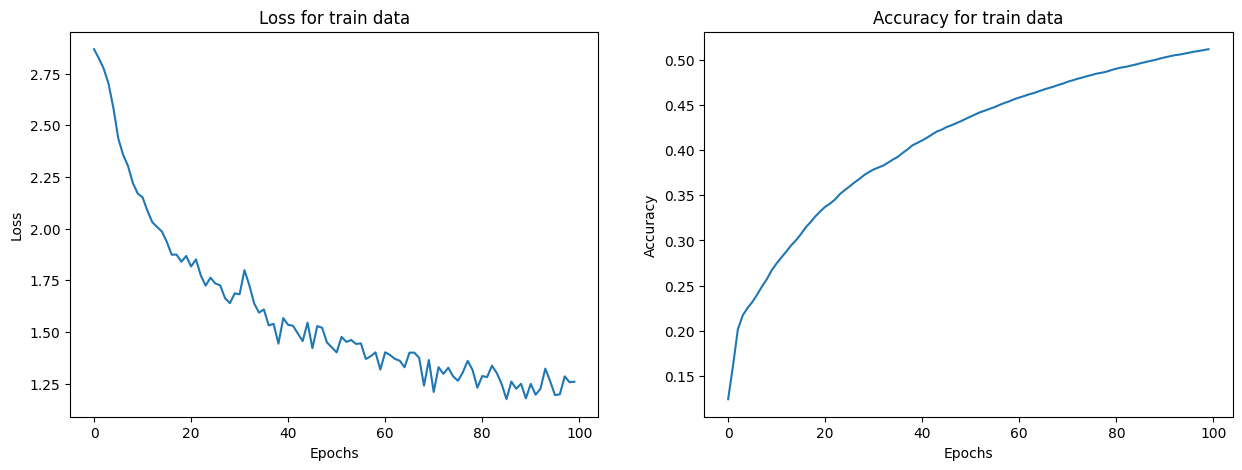

In [ ]:
show_plots(all_losses,all_acc, title_1='Loss for train data',title_2='Accuracy for train data')

In [ ]:
# training the baseline model
criterion = nn.NLLLoss()
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
optimizer = torch.optim.SGD(rnn_basic.parameters(), lr=learning_rate)

all_losses, current_loss, all_acc, accuracy = train_function(model=rnn_basic, data=val_data, n_iters=100000, print_every=5000, plot_every=1000, optimizer=optimizer, criterion=criterion)

  0%|          | 0/100000 [00:00<?, ?it/s]

5000 5% (1m 29s) 2.4658 Lennon / English ✗ (Irish) 0.6050
iter: 5000 | processed: 5.00% | time: 1m 29s | loss: 2.4658 |  acc: 0.6050
10000 10% (1m 33s) 1.0355 Rivero / Spanish ✓ 0.6097
iter: 10000 | processed: 10.00% | time: 1m 33s | loss: 1.0355 |  acc: 0.6097
15000 15% (1m 37s) 0.2630 Safar / Arabic ✓ 0.6144
iter: 15000 | processed: 15.00% | time: 1m 37s | loss: 0.2630 |  acc: 0.6144
20000 20% (1m 41s) 0.1139 Khouri / Arabic ✓ 0.6141
iter: 20000 | processed: 20.00% | time: 1m 41s | loss: 0.1139 |  acc: 0.6141
25000 25% (1m 46s) 0.4362 Kawachi / Japanese ✓ 0.6145
iter: 25000 | processed: 25.00% | time: 1m 46s | loss: 0.4362 |  acc: 0.6145
30000 30% (1m 50s) 1.8552 Fleming / German ✗ (Scottish) 0.6153
iter: 30000 | processed: 30.00% | time: 1m 50s | loss: 1.8552 |  acc: 0.6153
35000 35% (1m 54s) 0.8184 Kann / Dutch ✓ 0.6152
iter: 35000 | processed: 35.00% | time: 1m 54s | loss: 0.8184 |  acc: 0.6152
40000 40% (1m 58s) 3.8086 King / Chinese ✗ (Scottish) 0.6168
iter: 40000 | processed: 4

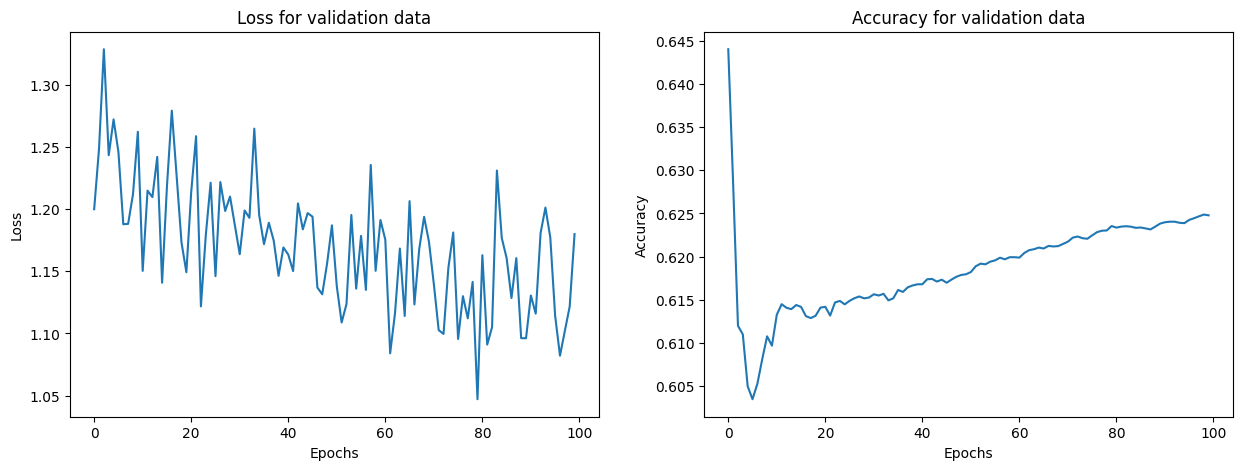

In [ ]:
show_plots(all_losses,all_acc,title_1='Loss for validation data',title_2='Accuracy for validation data')

## Hyperparameter tuning with Val data

In [ ]:
import itertools
# hyperparameters
lr = [0.001, 0.002, 0.003, 0.004, 0.005] # learning rate
weight_decay = [1e-2, 1e-3] # L2 regularization

parms_comb = list(itertools.product(lr, weight_decay))

experiment number:  1 out of:  10
learning rate:  0.001 weight decay:  0.01


  0%|          | 0/100000 [00:00<?, ?it/s]

5000 5% (2m 54s) 0.3031 Kozlow / Polish ✓ 0.6538
iter: 5000 | processed: 5.00% | time: 2m 54s | loss: 0.3031 |  acc: 0.6538
10000 10% (2m 59s) 0.5753 Paulissen / Dutch ✓ 0.6436
iter: 10000 | processed: 10.00% | time: 2m 59s | loss: 0.5753 |  acc: 0.6436
15000 15% (3m 3s) 1.1284 Hama / Japanese ✓ 0.6301
iter: 15000 | processed: 15.00% | time: 3m 3s | loss: 1.1284 |  acc: 0.6301
20000 20% (3m 7s) 2.1366 Krol / Scottish ✗ (Polish) 0.6143
iter: 20000 | processed: 20.00% | time: 3m 7s | loss: 2.1366 |  acc: 0.6143
25000 25% (3m 12s) 2.0438 Severins / German ✗ (Dutch) 0.6063
iter: 25000 | processed: 25.00% | time: 3m 12s | loss: 2.0438 |  acc: 0.6063
30000 30% (3m 16s) 0.5235 Shiskikura / Japanese ✓ 0.5962
iter: 30000 | processed: 30.00% | time: 3m 16s | loss: 0.5235 |  acc: 0.5962
35000 35% (3m 20s) 1.2304 La / Vietnamese ✓ 0.5861
iter: 35000 | processed: 35.00% | time: 3m 20s | loss: 1.2304 |  acc: 0.5861
40000 40% (3m 25s) 1.7203 Pena / Spanish ✓ 0.5788
iter: 40000 | processed: 40.00% | t

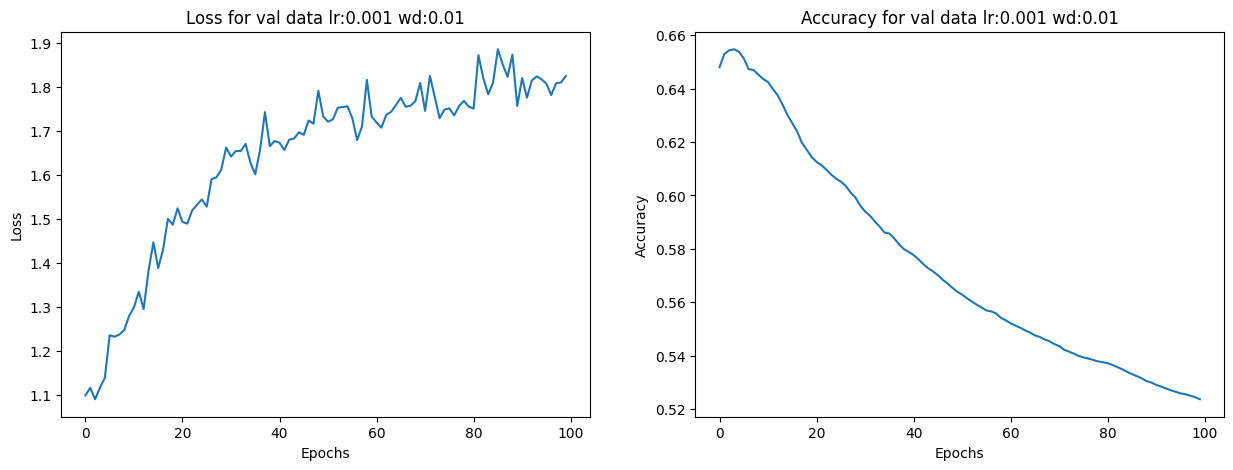

experiment number:  2 out of:  10
learning rate:  0.001 weight decay:  0.001


  0%|          | 0/100000 [00:00<?, ?it/s]

5000 5% (4m 21s) 1.6704 Shamoon / English ✗ (Arabic) 0.6458
iter: 5000 | processed: 5.00% | time: 4m 21s | loss: 1.6704 |  acc: 0.6458
10000 10% (4m 26s) 0.0407 Brunetti / Italian ✓ 0.6476
iter: 10000 | processed: 10.00% | time: 4m 26s | loss: 0.0407 |  acc: 0.6476
15000 15% (4m 30s) 1.6437 Wruck / Scottish ✗ (German) 0.6457
iter: 15000 | processed: 15.00% | time: 4m 30s | loss: 1.6437 |  acc: 0.6457
20000 20% (4m 34s) 0.2371 Koury / Arabic ✓ 0.6464
iter: 20000 | processed: 20.00% | time: 4m 34s | loss: 0.2371 |  acc: 0.6464
25000 25% (4m 39s) 0.3750 Mach / Vietnamese ✓ 0.6457
iter: 25000 | processed: 25.00% | time: 4m 39s | loss: 0.3750 |  acc: 0.6457
30000 30% (4m 43s) 0.8264 Addario / Italian ✓ 0.6445
iter: 30000 | processed: 30.00% | time: 4m 43s | loss: 0.8264 |  acc: 0.6445
35000 35% (4m 47s) 0.2765 Urbanovska / Czech ✓ 0.6443
iter: 35000 | processed: 35.00% | time: 4m 47s | loss: 0.2765 |  acc: 0.6443
40000 40% (4m 52s) 0.6270 Shim / Korean ✓ 0.6432
iter: 40000 | processed: 40.0

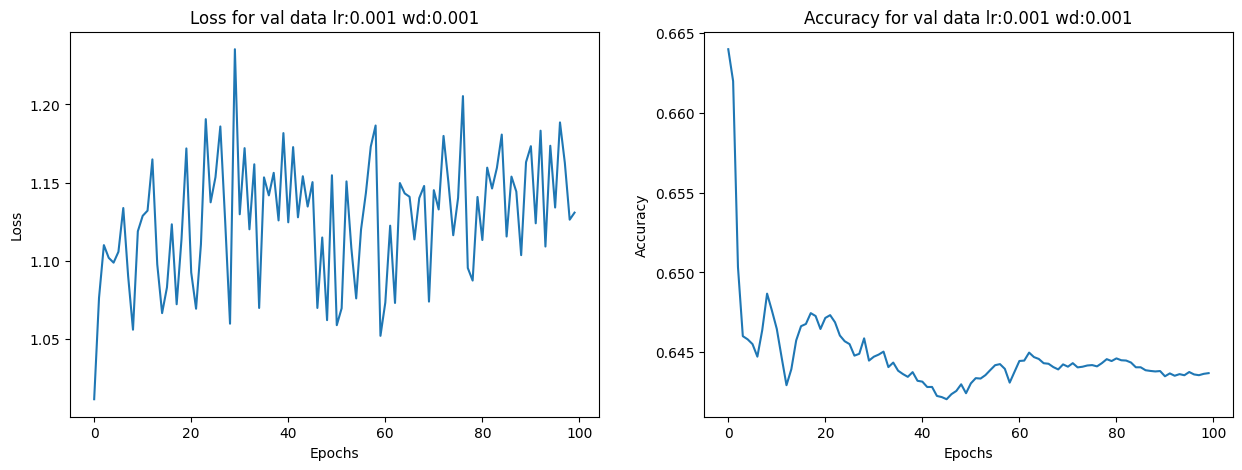

best parameters so far, lr:0.001, wd:0.001
experiment number:  3 out of:  10
learning rate:  0.002 weight decay:  0.01


  0%|          | 0/100000 [00:00<?, ?it/s]

5000 5% (5m 48s) 0.4781 Hruska / Czech ✓ 0.6472
iter: 5000 | processed: 5.00% | time: 5m 48s | loss: 0.4781 |  acc: 0.6472
10000 10% (5m 52s) 0.1085 O'Doherty / Irish ✓ 0.6384
iter: 10000 | processed: 10.00% | time: 5m 52s | loss: 0.1085 |  acc: 0.6384
15000 15% (5m 56s) 0.6100 Machado / Portuguese ✓ 0.6267
iter: 15000 | processed: 15.00% | time: 5m 56s | loss: 0.6100 |  acc: 0.6267
20000 20% (6m 1s) 1.5516 Mendes / Portuguese ✓ 0.6178
iter: 20000 | processed: 20.00% | time: 6m 1s | loss: 1.5516 |  acc: 0.6178
25000 25% (6m 5s) 0.6933 Ikeda / Japanese ✓ 0.6082
iter: 25000 | processed: 25.00% | time: 6m 5s | loss: 0.6933 |  acc: 0.6082
30000 30% (6m 10s) 1.9559 Quirke / Irish ✓ 0.5977
iter: 30000 | processed: 30.00% | time: 6m 10s | loss: 1.9559 |  acc: 0.5977
35000 35% (6m 14s) 1.4310 Kijek / Czech ✗ (Polish) 0.5875
iter: 35000 | processed: 35.00% | time: 6m 14s | loss: 1.4310 |  acc: 0.5875
40000 40% (6m 19s) 1.0251 Man / Chinese ✓ 0.5786
iter: 40000 | processed: 40.00% | time: 6m 19s

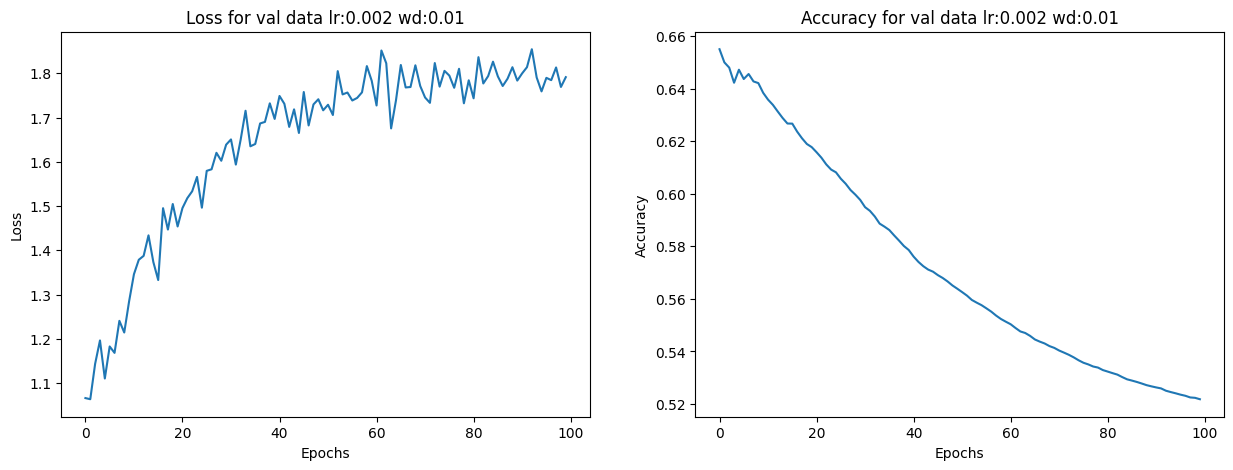

experiment number:  4 out of:  10
learning rate:  0.002 weight decay:  0.001


  0%|          | 0/100000 [00:00<?, ?it/s]

5000 5% (7m 15s) 0.6330 Tron / Vietnamese ✓ 0.6336
iter: 5000 | processed: 5.00% | time: 7m 15s | loss: 0.6330 |  acc: 0.6336
10000 10% (7m 20s) 0.1628 Zhi / Chinese ✓ 0.6346
iter: 10000 | processed: 10.00% | time: 7m 20s | loss: 0.1628 |  acc: 0.6346
15000 15% (7m 24s) 0.3902 Si / Korean ✓ 0.6369
iter: 15000 | processed: 15.00% | time: 7m 24s | loss: 0.3902 |  acc: 0.6369
20000 20% (7m 28s) 0.8468 Borovski / Czech ✓ 0.6340
iter: 20000 | processed: 20.00% | time: 7m 28s | loss: 0.8468 |  acc: 0.6340
25000 25% (7m 33s) 0.3436 Araullo / Portuguese ✓ 0.6348
iter: 25000 | processed: 25.00% | time: 7m 33s | loss: 0.3436 |  acc: 0.6348
30000 30% (7m 37s) 2.1665 Chieu / Vietnamese ✗ (Chinese) 0.6367
iter: 30000 | processed: 30.00% | time: 7m 37s | loss: 2.1665 |  acc: 0.6367
35000 35% (7m 41s) 0.1290 Thach / Vietnamese ✓ 0.6365
iter: 35000 | processed: 35.00% | time: 7m 41s | loss: 0.1290 |  acc: 0.6365
40000 40% (7m 46s) 1.6178 Marshall / Irish ✗ (Scottish) 0.6362
iter: 40000 | processed: 40

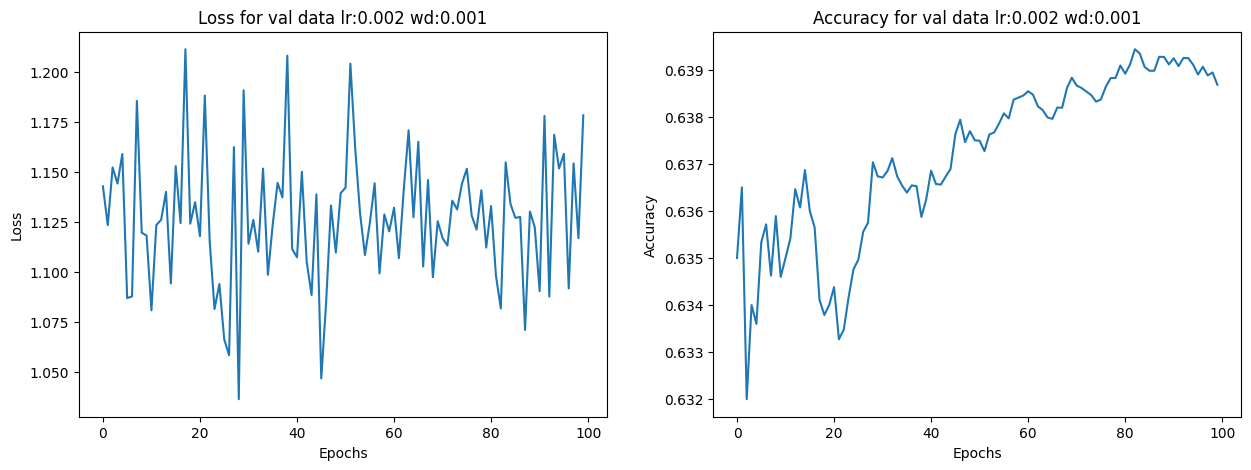

experiment number:  5 out of:  10
learning rate:  0.003 weight decay:  0.01


  0%|          | 0/100000 [00:00<?, ?it/s]

5000 5% (8m 42s) 0.1234 Gorecki / Polish ✓ 0.6462
iter: 5000 | processed: 5.00% | time: 8m 42s | loss: 0.1234 |  acc: 0.6462
10000 10% (8m 46s) 1.6683 Alden / Dutch ✗ (English) 0.6340
iter: 10000 | processed: 10.00% | time: 8m 46s | loss: 1.6683 |  acc: 0.6340
15000 15% (8m 51s) 1.2469 Robledo / Spanish ✓ 0.6231
iter: 15000 | processed: 15.00% | time: 8m 51s | loss: 1.2469 |  acc: 0.6231
20000 20% (8m 55s) 0.6411 Akkeren / Dutch ✓ 0.6129
iter: 20000 | processed: 20.00% | time: 8m 55s | loss: 0.6411 |  acc: 0.6129
25000 25% (8m 59s) 2.5523 Maeda / Spanish ✗ (Japanese) 0.6010
iter: 25000 | processed: 25.00% | time: 8m 59s | loss: 2.5523 |  acc: 0.6010
30000 30% (9m 4s) 1.0912 Gniewek / Polish ✓ 0.5919
iter: 30000 | processed: 30.00% | time: 9m 4s | loss: 1.0912 |  acc: 0.5919
35000 35% (9m 8s) 1.4343 Albuquerque / Portuguese ✓ 0.5817
iter: 35000 | processed: 35.00% | time: 9m 8s | loss: 1.4343 |  acc: 0.5817
40000 40% (9m 12s) 3.2705 Qureshi / Italian ✗ (Arabic) 0.5730
iter: 40000 | proc

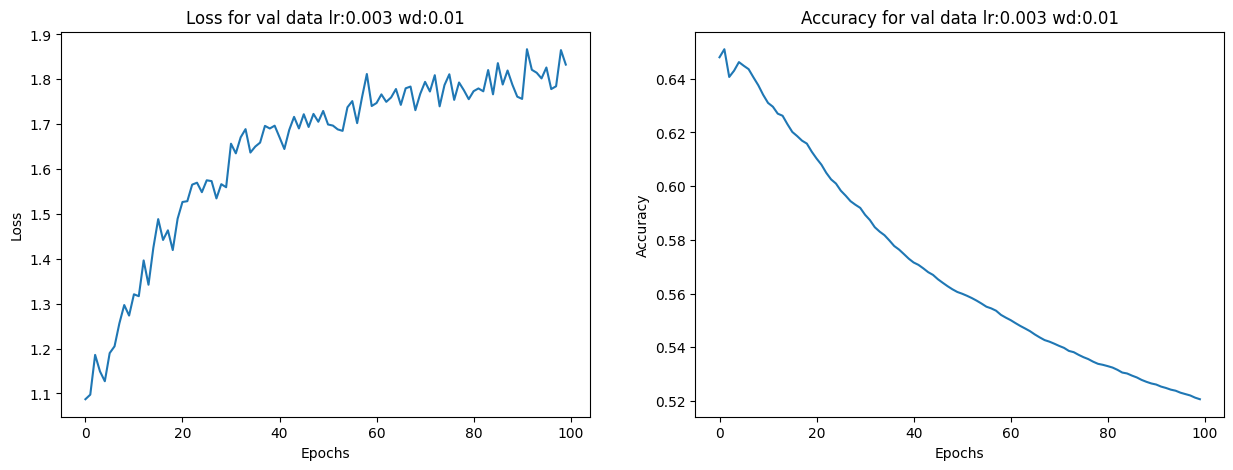

experiment number:  6 out of:  10
learning rate:  0.003 weight decay:  0.001


  0%|          | 0/100000 [00:00<?, ?it/s]

5000 5% (10m 9s) 0.1016 Zhuo / Chinese ✓ 0.6438
iter: 5000 | processed: 5.00% | time: 10m 9s | loss: 0.1016 |  acc: 0.6438
10000 10% (10m 13s) 2.1469 Pastore / French ✗ (Italian) 0.6421
iter: 10000 | processed: 10.00% | time: 10m 13s | loss: 2.1469 |  acc: 0.6421
15000 15% (10m 18s) 0.1857 Atiyeh / Arabic ✓ 0.6449
iter: 15000 | processed: 15.00% | time: 10m 18s | loss: 0.1857 |  acc: 0.6449
20000 20% (10m 22s) 0.9307 Wirnhier / German ✓ 0.6463
iter: 20000 | processed: 20.00% | time: 10m 22s | loss: 0.9307 |  acc: 0.6463
25000 25% (10m 26s) 2.4638 Romero / Dutch ✗ (Spanish) 0.6450
iter: 25000 | processed: 25.00% | time: 10m 26s | loss: 2.4638 |  acc: 0.6450
30000 30% (10m 31s) 1.8857 Mata / Japanese ✗ (Spanish) 0.6445
iter: 30000 | processed: 30.00% | time: 10m 31s | loss: 1.8857 |  acc: 0.6445
35000 35% (10m 35s) 1.1838 Ramaaker / Dutch ✓ 0.6459
iter: 35000 | processed: 35.00% | time: 10m 35s | loss: 1.1838 |  acc: 0.6459
40000 40% (10m 39s) 1.4769 Ryzhik / Polish ✗ (Russian) 0.6470
it

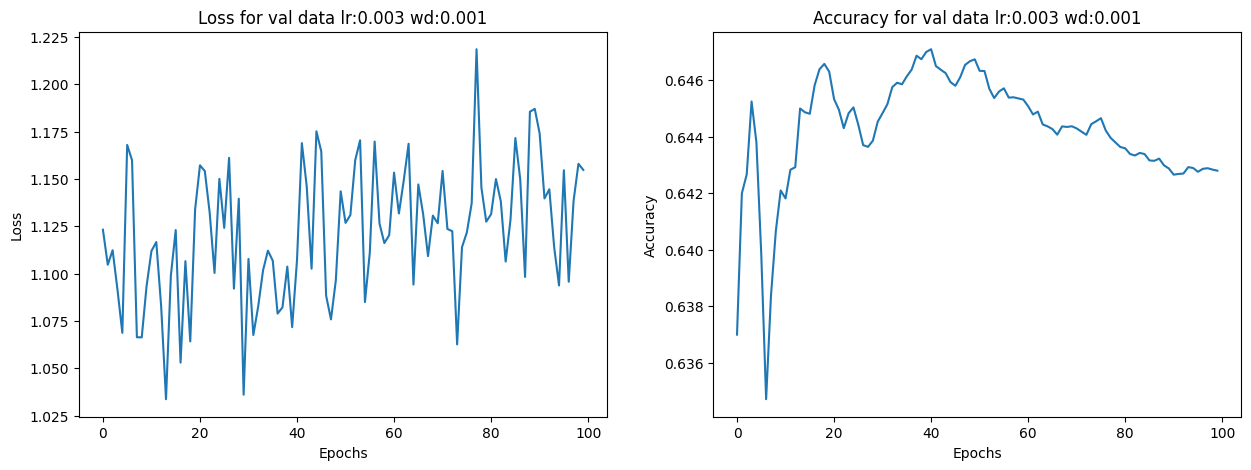

experiment number:  7 out of:  10
learning rate:  0.004 weight decay:  0.01


  0%|          | 0/100000 [00:00<?, ?it/s]

5000 5% (11m 36s) 0.9333 Pinheiro / Portuguese ✓ 0.6438
iter: 5000 | processed: 5.00% | time: 11m 36s | loss: 0.9333 |  acc: 0.6438
10000 10% (11m 40s) 0.3169 Phung / Vietnamese ✓ 0.6333
iter: 10000 | processed: 10.00% | time: 11m 40s | loss: 0.3169 |  acc: 0.6333
15000 15% (11m 44s) 1.0987 Mathghamhain / Irish ✓ 0.6245
iter: 15000 | processed: 15.00% | time: 11m 44s | loss: 1.0987 |  acc: 0.6245
20000 20% (11m 49s) 3.1168 Truman / Vietnamese ✗ (English) 0.6131
iter: 20000 | processed: 20.00% | time: 11m 49s | loss: 3.1168 |  acc: 0.6131
25000 25% (11m 53s) 1.6153 Momotani / Italian ✗ (Japanese) 0.6016
iter: 25000 | processed: 25.00% | time: 11m 53s | loss: 1.6153 |  acc: 0.6016
30000 30% (11m 57s) 2.5090 Cleirigh / French ✗ (Irish) 0.5900
iter: 30000 | processed: 30.00% | time: 11m 57s | loss: 2.5090 |  acc: 0.5900
35000 35% (12m 2s) 1.5425 Ma / Vietnamese ✓ 0.5807
iter: 35000 | processed: 35.00% | time: 12m 2s | loss: 1.5425 |  acc: 0.5807
40000 40% (12m 6s) 5.5659 Dubhshlaine / Russ

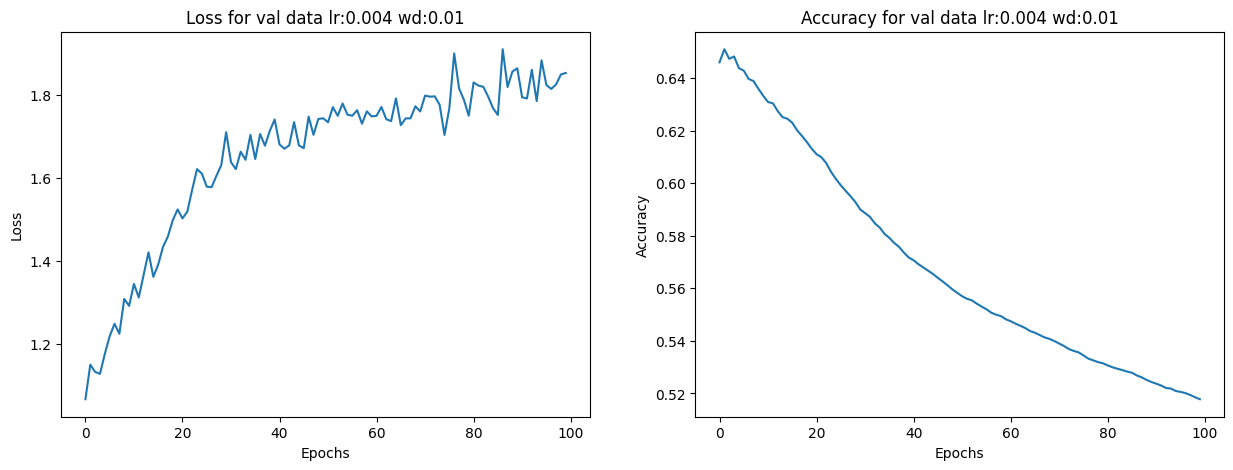

experiment number:  8 out of:  10
learning rate:  0.004 weight decay:  0.001


  0%|          | 0/100000 [00:00<?, ?it/s]

5000 5% (13m 3s) 0.2143 Mckenzie / Scottish ✓ 0.6296
iter: 5000 | processed: 5.00% | time: 13m 3s | loss: 0.2143 |  acc: 0.6296
10000 10% (13m 7s) 0.4904 Ohmae / Japanese ✓ 0.6353
iter: 10000 | processed: 10.00% | time: 13m 7s | loss: 0.4904 |  acc: 0.6353
15000 15% (13m 12s) 1.5552 Gass / Arabic ✗ (German) 0.6378
iter: 15000 | processed: 15.00% | time: 13m 12s | loss: 1.5552 |  acc: 0.6378
20000 20% (13m 16s) 0.3037 Wei / Chinese ✓ 0.6383
iter: 20000 | processed: 20.00% | time: 13m 16s | loss: 0.3037 |  acc: 0.6383
25000 25% (13m 21s) 1.0524 Shui / Korean ✗ (Chinese) 0.6408
iter: 25000 | processed: 25.00% | time: 13m 21s | loss: 1.0524 |  acc: 0.6408
30000 30% (13m 25s) 1.5031 Vargas / Spanish ✓ 0.6399
iter: 30000 | processed: 30.00% | time: 13m 25s | loss: 1.5031 |  acc: 0.6399
35000 35% (13m 30s) 0.0835 O'Toole / Irish ✓ 0.6400
iter: 35000 | processed: 35.00% | time: 13m 30s | loss: 0.0835 |  acc: 0.6400
40000 40% (13m 34s) 0.0401 Taflambas / Greek ✓ 0.6397
iter: 40000 | processed: 

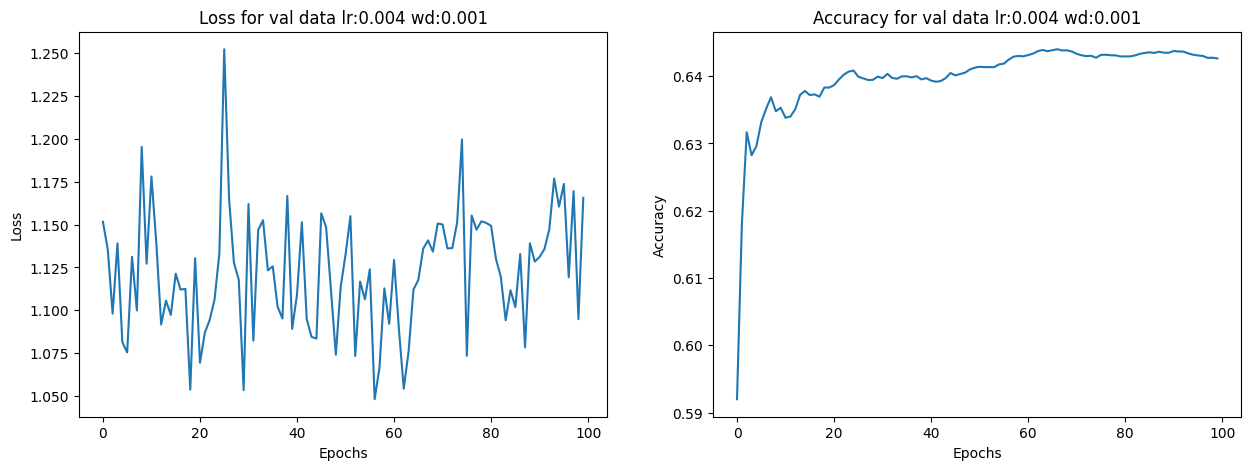

experiment number:  9 out of:  10
learning rate:  0.005 weight decay:  0.01


  0%|          | 0/100000 [00:00<?, ?it/s]

5000 5% (14m 31s) 3.0738 Firmin / Irish ✗ (French) 0.6534
iter: 5000 | processed: 5.00% | time: 14m 31s | loss: 3.0738 |  acc: 0.6534
10000 10% (14m 36s) 1.1116 Kim / Korean ✓ 0.6413
iter: 10000 | processed: 10.00% | time: 14m 36s | loss: 1.1116 |  acc: 0.6413
15000 15% (14m 40s) 1.8618 Karl / Dutch ✓ 0.6299
iter: 15000 | processed: 15.00% | time: 14m 40s | loss: 1.8618 |  acc: 0.6299
20000 20% (14m 44s) 0.0905 Shammas / Arabic ✓ 0.6231
iter: 20000 | processed: 20.00% | time: 14m 44s | loss: 0.0905 |  acc: 0.6231
25000 25% (14m 49s) 0.4046 Groskov / Russian ✓ 0.6117
iter: 25000 | processed: 25.00% | time: 14m 49s | loss: 0.4046 |  acc: 0.6117
30000 30% (14m 53s) 1.6400 Kouri / Japanese ✗ (Arabic) 0.6003
iter: 30000 | processed: 30.00% | time: 14m 53s | loss: 1.6400 |  acc: 0.6003
35000 35% (14m 57s) 1.1756 Johnston / Scottish ✓ 0.5899
iter: 35000 | processed: 35.00% | time: 14m 57s | loss: 1.1756 |  acc: 0.5899
40000 40% (15m 2s) 1.4176 Souza / Portuguese ✓ 0.5807
iter: 40000 | process

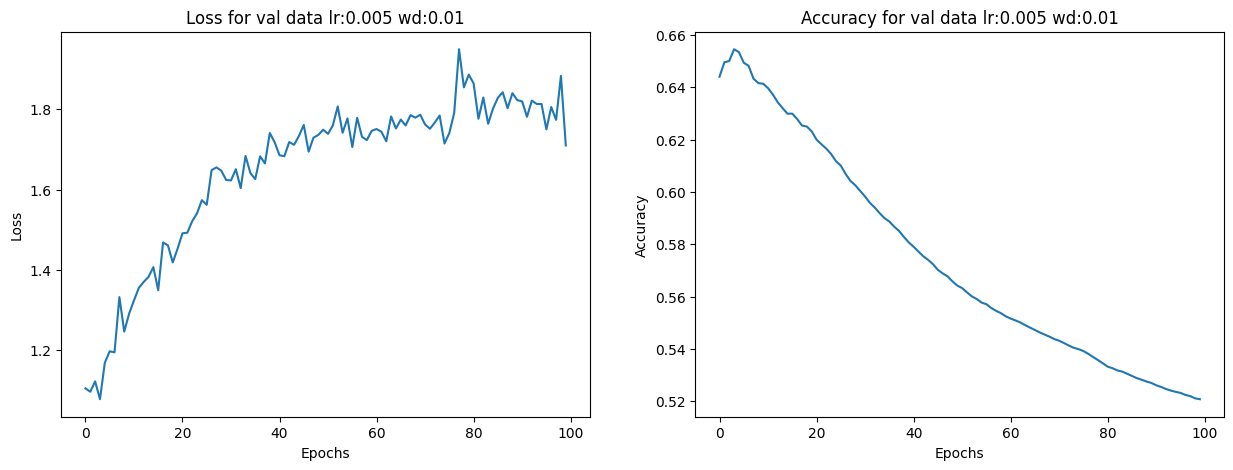

experiment number:  10 out of:  10
learning rate:  0.005 weight decay:  0.001


  0%|          | 0/100000 [00:00<?, ?it/s]

5000 5% (15m 59s) 0.0744 Yan / Chinese ✓ 0.6334
iter: 5000 | processed: 5.00% | time: 15m 59s | loss: 0.0744 |  acc: 0.6334
10000 10% (16m 3s) 0.0070 Eliopoulos / Greek ✓ 0.6417
iter: 10000 | processed: 10.00% | time: 16m 3s | loss: 0.0070 |  acc: 0.6417
15000 15% (16m 7s) 1.4857 Parrott / French ✗ (English) 0.6449
iter: 15000 | processed: 15.00% | time: 16m 7s | loss: 1.4857 |  acc: 0.6449
20000 20% (16m 11s) 0.6144 Hoang / Vietnamese ✓ 0.6473
iter: 20000 | processed: 20.00% | time: 16m 11s | loss: 0.6144 |  acc: 0.6473
25000 25% (16m 16s) 0.6183 Theofilopoulos / Greek ✓ 0.6480
iter: 25000 | processed: 25.00% | time: 16m 16s | loss: 0.6183 |  acc: 0.6480
30000 30% (16m 20s) 1.3930 Spano / Chinese ✗ (Italian) 0.6471
iter: 30000 | processed: 30.00% | time: 16m 20s | loss: 1.3930 |  acc: 0.6471
35000 35% (16m 24s) 1.0922 Prchal / Czech ✓ 0.6484
iter: 35000 | processed: 35.00% | time: 16m 24s | loss: 1.0922 |  acc: 0.6484
40000 40% (16m 29s) 0.7070 Safar / Arabic ✓ 0.6481
iter: 40000 | pr

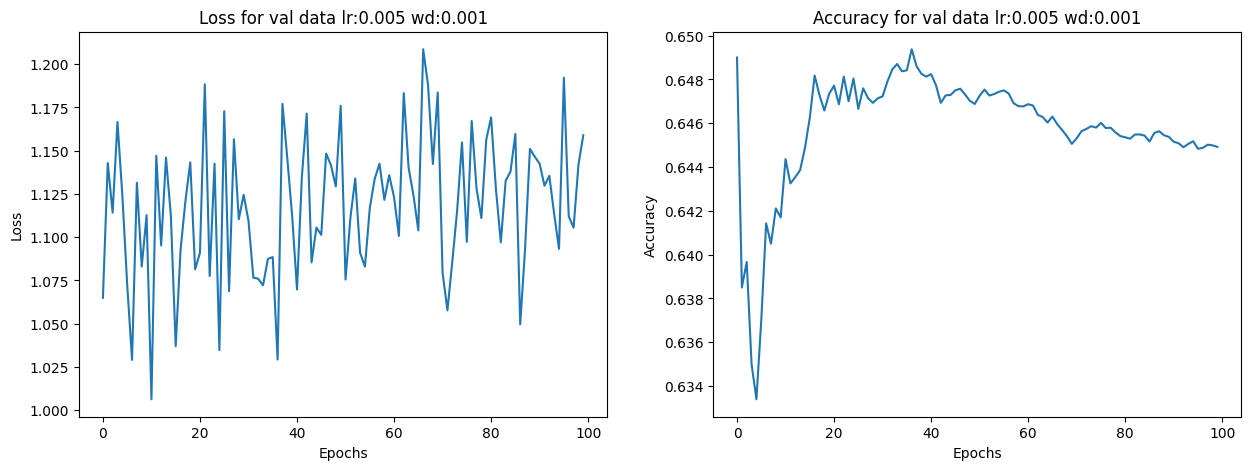

best parameters so far, lr:0.005, wd:0.001


In [ ]:
import copy
cur_acc = accuracy
criterion = nn.NLLLoss()

for parm in parms_comb:
    new_model = RNNBasic(len(ALL_LETTERS), n_hidden, len(CLASSES)).to(device)
    new_model.load_state_dict(copy.deepcopy(rnn_basic.state_dict()))

    print('experiment number: ', parms_comb.index(parm)+1, 'out of: ', len(parms_comb))
    print('learning rate: ', parm[0], 'weight decay: ', parm[1])    
    optimizer = torch.optim.SGD(new_model.parameters(), lr=learning_rate,weight_decay=parm[1])

    all_losses,current_loss,all_acc,accuracy = train_function(model=new_model, data=val_data, n_iters=100000, print_every=5000, plot_every=1000,optimizer=optimizer, criterion=criterion)
    show_plots(all_losses, all_acc,title_1=f'Loss for val data lr:{parm[0]} wd:{parm[1]}',title_2=f'Accuracy for val data lr:{parm[0]} wd:{parm[1]}')
    if accuracy > cur_acc:
        cur_acc = accuracy
        best_lr = parm[0]
        best_wd = parm[1]
        print(f'best parameters so far, lr:{best_lr}, wd:{best_wd}')
        torch.save(new_model.state_dict(), f'best_model_lr_{best_lr}_wd_{best_wd}.pth')

## Loading Best Model

In [ ]:
best_model_name = f"best_model_lr_{best_lr}_wd_{best_wd}.pth"
best_model_base = RNNBasic(len(ALL_LETTERS), n_hidden, len(CLASSES)).to(device)
best_model_base.load_state_dict(torch.load(best_model_name))
best_model_base.eval()

RNNBasic(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)

## Evaluating Confusion Matrix

/tmp/ipykernel_1353979/1639974376.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(CLASSES, rotation=90)
/tmp/ipykernel_1353979/1639974376.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(CLASSES)


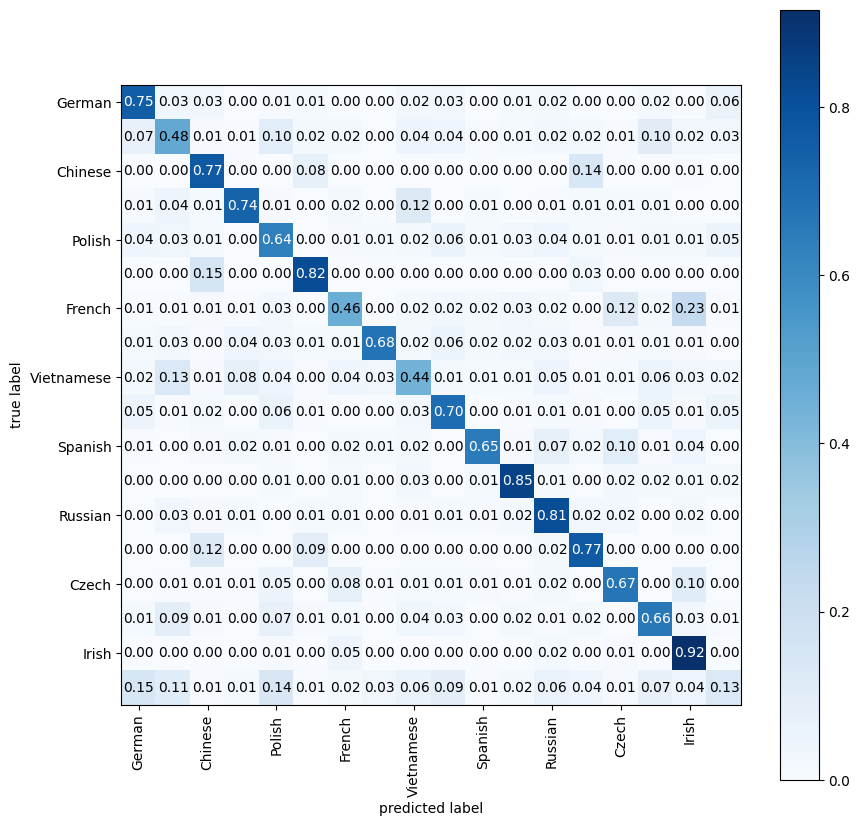

In [ ]:
from mlxtend.plotting import plot_confusion_matrix



# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(len(CLASSES), len(CLASSES))
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = best_model_base.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = best_model_base(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample(data=val_data)
    output = evaluate(line_tensor)
    guess, guess_i = lang_from_output(output)
    category_i = CLASSES.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(len(CLASSES)):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig, ax = plot_confusion_matrix(conf_mat=confusion.numpy(),
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True)
# Set up axes
ax.set_xticklabels(CLASSES, rotation=90)
ax.set_yticklabels(CLASSES)

fig.set_size_inches(10, 10)
fig.show()

## Add three more linear layers to our current RNN architecture

In [ ]:
import torch.nn as nn

# source: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

class RNNExtraLayers(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o_0 = nn.Linear(input_size + hidden_size, input_size + hidden_size)
        self.i2o_1 = nn.Linear(input_size + hidden_size, input_size + hidden_size)
        self.i2o_2 = nn.Linear(input_size + hidden_size, input_size + hidden_size)
        self.i2o_3 = nn.Linear(input_size + hidden_size, output_size)
        self.tanh = nn.Tanh()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o_0(combined)
        output = self.tanh(output)
        # print(f"out shape layer_0: {output.shape}")
        output = self.i2o_1(output)
        output = self.tanh(output)
        # print(f"out shape layer_1: {output.shape}")
        output = self.i2o_2(output)
        output = self.tanh(output)
        # print(f"out shape layer_2: {output.shape}")
        output = self.i2o_3(output)
        # print(f"out shape layer_3: {output.shape}")
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [ ]:
rnn_extra_layers = RNNExtraLayers(len(ALL_LETTERS), n_hidden, len(CLASSES)).to(device)

In [ ]:
# training the baseline model
criterion = nn.NLLLoss()
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
optimizer = torch.optim.SGD(rnn_extra_layers.parameters(), lr=learning_rate)

all_losses, current_loss, all_acc, accuracy = train_function(model=rnn_extra_layers, data=train_data, n_iters=100000, print_every=5000, plot_every=1000, optimizer=optimizer, criterion=criterion)

  0%|          | 0/100000 [00:00<?, ?it/s]

5000 5% (17m 35s) 2.8787 Obando / Italian ✗ (Spanish) 0.1030
iter: 5000 | processed: 5.00% | time: 17m 35s | loss: 2.8787 |  acc: 0.1030
10000 10% (17m 44s) 2.4425 Kulhanek / Polish ✗ (Czech) 0.1577
iter: 10000 | processed: 10.00% | time: 17m 44s | loss: 2.4425 |  acc: 0.1577
15000 15% (17m 52s) 1.3809 Bishara / Arabic ✓ 0.2077
iter: 15000 | processed: 15.00% | time: 17m 52s | loss: 1.3809 |  acc: 0.2077
20000 20% (18m 1s) 0.9563 Ocaskova / Czech ✓ 0.2535
iter: 20000 | processed: 20.00% | time: 18m 1s | loss: 0.9563 |  acc: 0.2535
25000 25% (18m 9s) 0.1688 Egonidis / Greek ✓ 0.2914
iter: 25000 | processed: 25.00% | time: 18m 9s | loss: 0.1688 |  acc: 0.2914
30000 30% (18m 18s) 0.4178 Agani / Italian ✓ 0.3230
iter: 30000 | processed: 30.00% | time: 18m 18s | loss: 0.4178 |  acc: 0.3230
35000 35% (18m 26s) 3.9423 Belmonte / Dutch ✗ (Spanish) 0.3489
iter: 35000 | processed: 35.00% | time: 18m 26s | loss: 3.9423 |  acc: 0.3489
40000 40% (18m 35s) 1.8517 Gagne / Irish ✗ (French) 0.3681
iter

### Loss and Accuracy plot

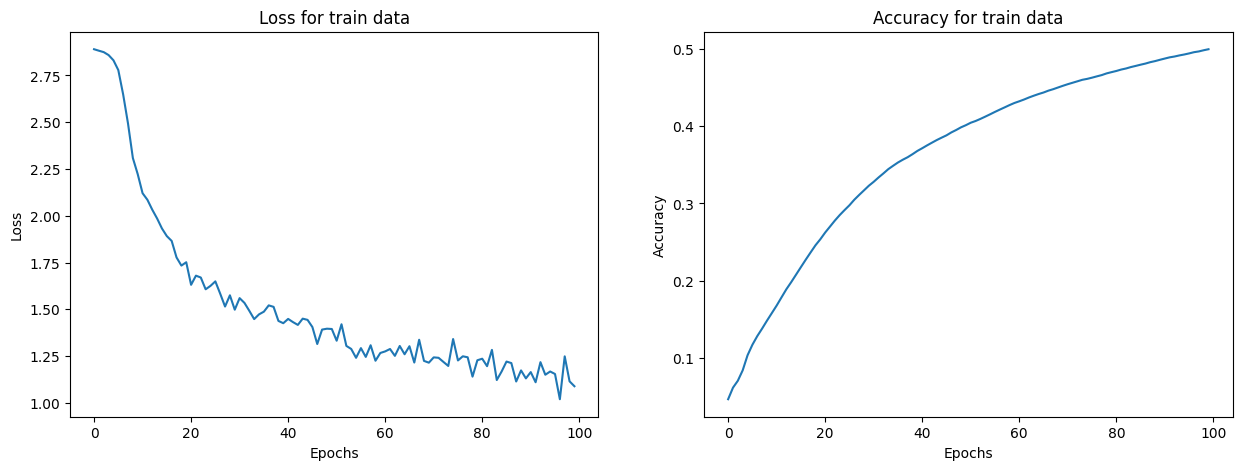

In [ ]:
show_plots(all_losses,all_acc, title_1='Loss for train data',title_2='Accuracy for train data')

In [ ]:
# training the baseline model
criterion = nn.NLLLoss()
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
optimizer = torch.optim.SGD(rnn_extra_layers.parameters(), lr=learning_rate)

all_losses, current_loss, all_acc, accuracy = train_function(model=rnn_extra_layers, data=val_data, n_iters=100000, print_every=5000, plot_every=1000, optimizer=optimizer, criterion=criterion)

  0%|          | 0/100000 [00:00<?, ?it/s]

5000 5% (20m 26s) 0.7494 Kwak / Korean ✓ 0.6286
iter: 5000 | processed: 5.00% | time: 20m 26s | loss: 0.7494 |  acc: 0.6286
10000 10% (20m 35s) 0.8972 Koning / Dutch ✓ 0.6345
iter: 10000 | processed: 10.00% | time: 20m 35s | loss: 0.8972 |  acc: 0.6345
15000 15% (20m 43s) 0.5236 Echevarria / Spanish ✓ 0.6375
iter: 15000 | processed: 15.00% | time: 20m 43s | loss: 0.5236 |  acc: 0.6375
20000 20% (20m 52s) 0.0452 Amari / Arabic ✓ 0.6435
iter: 20000 | processed: 20.00% | time: 20m 52s | loss: 0.0452 |  acc: 0.6435
25000 25% (21m 0s) 1.7453 Kennedy / English ✗ (Scottish) 0.6454
iter: 25000 | processed: 25.00% | time: 21m 0s | loss: 1.7453 |  acc: 0.6454
30000 30% (21m 9s) 0.3208 Doan / Vietnamese ✓ 0.6471
iter: 30000 | processed: 30.00% | time: 21m 9s | loss: 0.3208 |  acc: 0.6471
35000 35% (21m 18s) 3.6599 Fleming / English ✗ (Scottish) 0.6483
iter: 35000 | processed: 35.00% | time: 21m 18s | loss: 3.6599 |  acc: 0.6483
40000 40% (21m 27s) 0.0005 Zhemaldinov / Russian ✓ 0.6498
iter: 40000

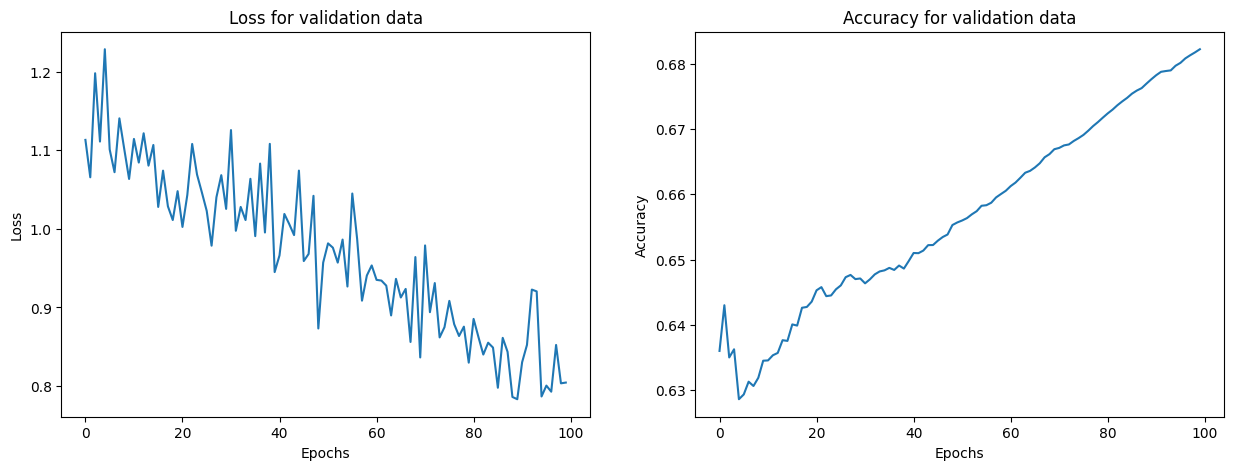

In [ ]:
show_plots(all_losses,all_acc,title_1='Loss for validation data',title_2='Accuracy for validation data')

## Hyperparameter tuning with Val data for extra layer model

In [ ]:
import itertools
# hyperparameters
lr = [0.001, 0.002, 0.003, 0.004, 0.005] # learning rate
weight_decay = [1e-2, 1e-3] # L2 regularization

parms_comb = list(itertools.product(lr, weight_decay))

experiment number:  1 out of:  10
learning rate:  0.001 weight decay:  0.01


  0%|          | 0/100000 [00:00<?, ?it/s]

5000 5% (23m 20s) 0.0346 Brzezicki / Polish ✓ 0.7344
iter: 5000 | processed: 5.00% | time: 23m 20s | loss: 0.0346 |  acc: 0.7344
10000 10% (23m 29s) 1.3473 Ramsay / French ✗ (Scottish) 0.7185
iter: 10000 | processed: 10.00% | time: 23m 29s | loss: 1.3473 |  acc: 0.7185
15000 15% (23m 38s) 0.4060 Babineaux / French ✓ 0.6947
iter: 15000 | processed: 15.00% | time: 23m 38s | loss: 0.4060 |  acc: 0.6947
20000 20% (23m 47s) 1.8116 Wendel / Dutch ✗ (German) 0.6767
iter: 20000 | processed: 20.00% | time: 23m 47s | loss: 1.8116 |  acc: 0.6767
25000 25% (23m 56s) 0.9262 Phi / Vietnamese ✓ 0.6619
iter: 25000 | processed: 25.00% | time: 23m 56s | loss: 0.9262 |  acc: 0.6619
30000 30% (24m 5s) 1.1175 Cuevas / Spanish ✓ 0.6472
iter: 30000 | processed: 30.00% | time: 24m 5s | loss: 1.1175 |  acc: 0.6472
35000 35% (24m 13s) 0.8648 Ta / Vietnamese ✓ 0.6352
iter: 35000 | processed: 35.00% | time: 24m 13s | loss: 0.8648 |  acc: 0.6352
40000 40% (24m 22s) 1.3120 Mentis / Greek ✓ 0.6238
iter: 40000 | proc

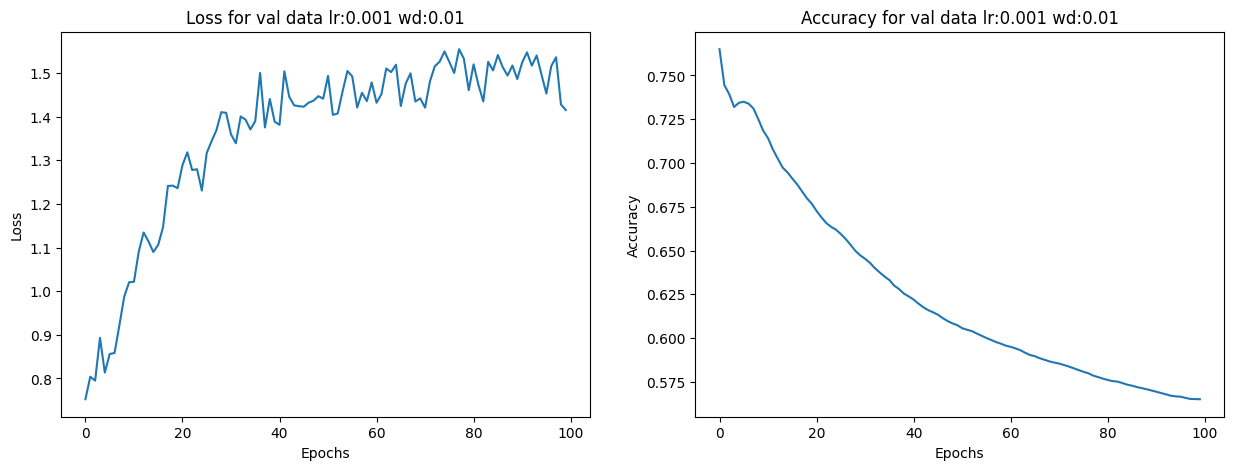

experiment number:  2 out of:  10
learning rate:  0.001 weight decay:  0.001


  0%|          | 0/100000 [00:00<?, ?it/s]

5000 5% (26m 18s) 0.7263 Milne / Scottish ✓ 0.7430
iter: 5000 | processed: 5.00% | time: 26m 18s | loss: 0.7263 |  acc: 0.7430
10000 10% (26m 27s) 6.9229 Ashia / Arabic ✗ (Japanese) 0.7399
iter: 10000 | processed: 10.00% | time: 26m 27s | loss: 6.9229 |  acc: 0.7399
15000 15% (26m 36s) 0.6226 Antonowitsch / Czech ✓ 0.7429
iter: 15000 | processed: 15.00% | time: 26m 36s | loss: 0.6226 |  acc: 0.7429
20000 20% (26m 45s) 0.0409 O'Halloran / Irish ✓ 0.7469
iter: 20000 | processed: 20.00% | time: 26m 45s | loss: 0.0409 |  acc: 0.7469
25000 25% (26m 54s) 0.1743 Yanagi / Japanese ✓ 0.7473
iter: 25000 | processed: 25.00% | time: 26m 54s | loss: 0.1743 |  acc: 0.7473
30000 30% (27m 3s) 0.0504 Shamon / Arabic ✓ 0.7466
iter: 30000 | processed: 30.00% | time: 27m 3s | loss: 0.0504 |  acc: 0.7466
35000 35% (27m 12s) 0.1138 Porra / Spanish ✓ 0.7491
iter: 35000 | processed: 35.00% | time: 27m 12s | loss: 0.1138 |  acc: 0.7491
40000 40% (27m 21s) 0.0818 Hasegawa / Japanese ✓ 0.7513
iter: 40000 | proce

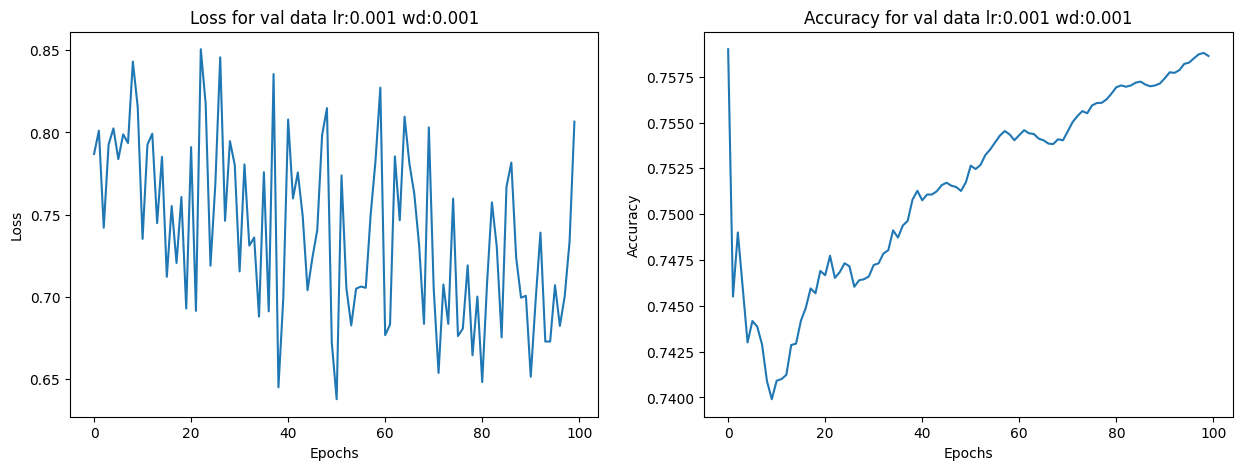

best parameters so far, lr:0.001, wd:0.001
experiment number:  3 out of:  10
learning rate:  0.002 weight decay:  0.01


  0%|          | 0/100000 [00:00<?, ?it/s]

5000 5% (29m 17s) 1.6357 O'Shea / Korean ✗ (Irish) 0.7458
iter: 5000 | processed: 5.00% | time: 29m 17s | loss: 1.6357 |  acc: 0.7458
10000 10% (29m 26s) 1.1404 Horigoshi / Italian ✗ (Japanese) 0.7203
iter: 10000 | processed: 10.00% | time: 29m 26s | loss: 1.1404 |  acc: 0.7203
15000 15% (29m 35s) 0.3043 Eoin / Irish ✓ 0.7009
iter: 15000 | processed: 15.00% | time: 29m 35s | loss: 0.3043 |  acc: 0.7009
20000 20% (29m 44s) 0.2811 Atiyeh / Arabic ✓ 0.6806
iter: 20000 | processed: 20.00% | time: 29m 44s | loss: 0.2811 |  acc: 0.6806
25000 25% (29m 52s) 1.0445 Mccallum / Scottish ✓ 0.6660
iter: 25000 | processed: 25.00% | time: 29m 52s | loss: 1.0445 |  acc: 0.6660
30000 30% (30m 1s) 0.1454 Rigatos / Greek ✓ 0.6522
iter: 30000 | processed: 30.00% | time: 30m 1s | loss: 0.1454 |  acc: 0.6522
35000 35% (30m 10s) 3.5150 Jagoda / Japanese ✗ (Polish) 0.6394
iter: 35000 | processed: 35.00% | time: 30m 10s | loss: 3.5150 |  acc: 0.6394
40000 40% (30m 19s) 0.1361 Horiatis / Greek ✓ 0.6262
iter: 40

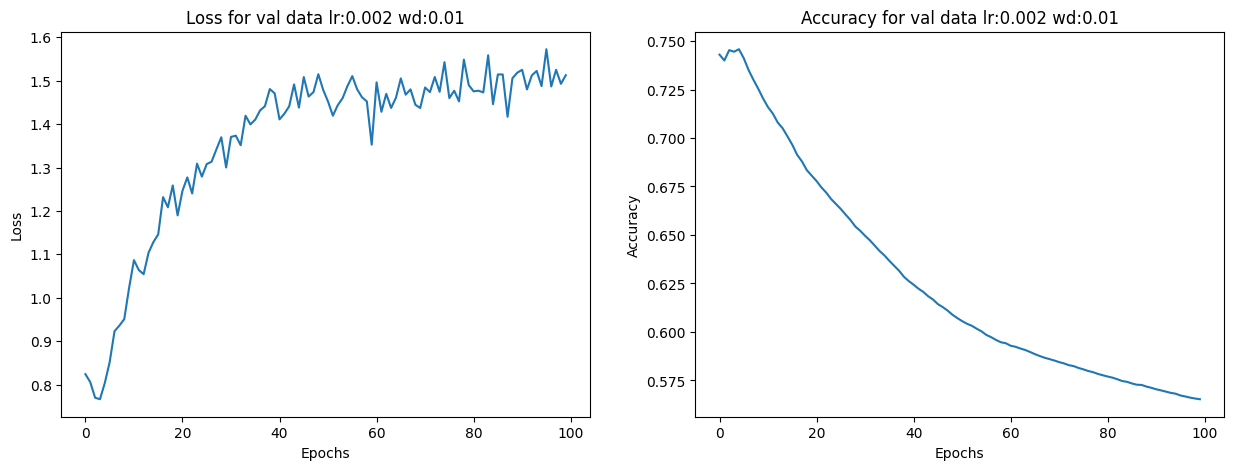

experiment number:  4 out of:  10
learning rate:  0.002 weight decay:  0.001


  0%|          | 0/100000 [00:00<?, ?it/s]

5000 5% (32m 16s) 2.6565 Romilly / English ✗ (French) 0.7398
iter: 5000 | processed: 5.00% | time: 32m 16s | loss: 2.6565 |  acc: 0.7398
10000 10% (32m 25s) 1.8742 Halle / French ✗ (German) 0.7401
iter: 10000 | processed: 10.00% | time: 32m 25s | loss: 1.8742 |  acc: 0.7401
15000 15% (32m 33s) 2.9005 Wizner / German ✗ (Czech) 0.7433
iter: 15000 | processed: 15.00% | time: 32m 33s | loss: 2.9005 |  acc: 0.7433
20000 20% (32m 42s) 0.0438 O'Grady / Irish ✓ 0.7441
iter: 20000 | processed: 20.00% | time: 32m 42s | loss: 0.0438 |  acc: 0.7441
25000 25% (32m 51s) 0.0466 Yep / Chinese ✓ 0.7479
iter: 25000 | processed: 25.00% | time: 32m 51s | loss: 0.0466 |  acc: 0.7479
30000 30% (33m 0s) 0.0446 Mertens / Dutch ✓ 0.7482
iter: 30000 | processed: 30.00% | time: 33m 0s | loss: 0.0446 |  acc: 0.7482
35000 35% (33m 9s) 1.9295 Upsdell / German ✗ (English) 0.7495
iter: 35000 | processed: 35.00% | time: 33m 9s | loss: 1.9295 |  acc: 0.7495
40000 40% (33m 18s) 1.8033 Bock / English ✗ (Czech) 0.7488
ite

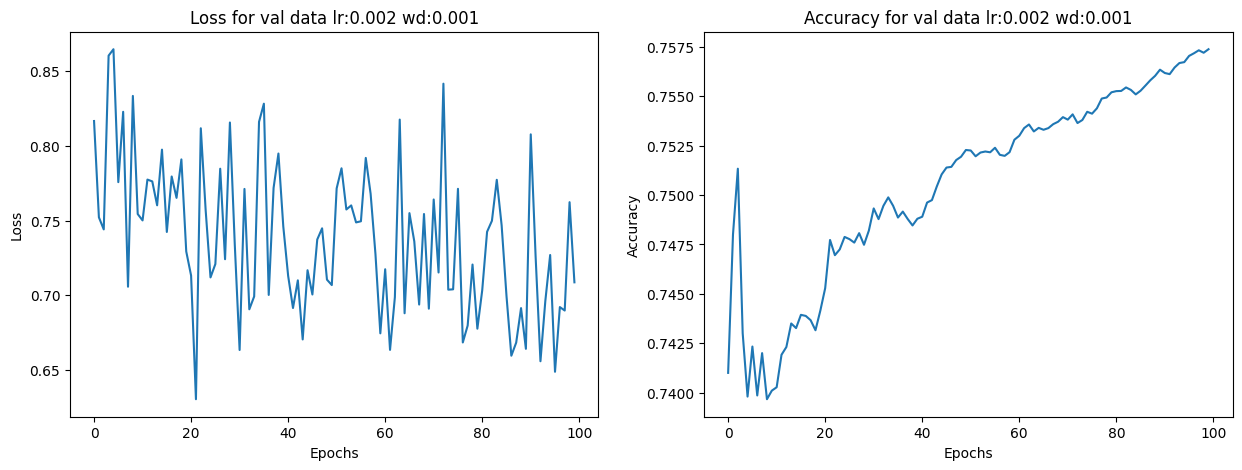

experiment number:  5 out of:  10
learning rate:  0.003 weight decay:  0.01


  0%|          | 0/100000 [00:00<?, ?it/s]

5000 5% (35m 14s) 0.4004 Saito / Japanese ✓ 0.7366
iter: 5000 | processed: 5.00% | time: 35m 14s | loss: 0.4004 |  acc: 0.7366
10000 10% (35m 22s) 0.8887 Wojda / Polish ✓ 0.7180
iter: 10000 | processed: 10.00% | time: 35m 22s | loss: 0.8887 |  acc: 0.7180
15000 15% (35m 30s) 1.2776 Ban / Vietnamese ✗ (Chinese) 0.6968
iter: 15000 | processed: 15.00% | time: 35m 30s | loss: 1.2776 |  acc: 0.6968
20000 20% (35m 39s) 0.3222 Tatsuko / Japanese ✓ 0.6754
iter: 20000 | processed: 20.00% | time: 35m 39s | loss: 0.3222 |  acc: 0.6754
25000 25% (35m 47s) 3.3002 Messerli / Italian ✗ (German) 0.6606
iter: 25000 | processed: 25.00% | time: 35m 47s | loss: 3.3002 |  acc: 0.6606
30000 30% (35m 55s) 0.8908 Tuma / Arabic ✓ 0.6466
iter: 30000 | processed: 30.00% | time: 35m 55s | loss: 0.8908 |  acc: 0.6466
35000 35% (36m 4s) 0.4497 Wyrzyk / Polish ✓ 0.6358
iter: 35000 | processed: 35.00% | time: 36m 4s | loss: 0.4497 |  acc: 0.6358
40000 40% (36m 12s) 2.3250 Teague / French ✗ (Irish) 0.6271
iter: 40000 

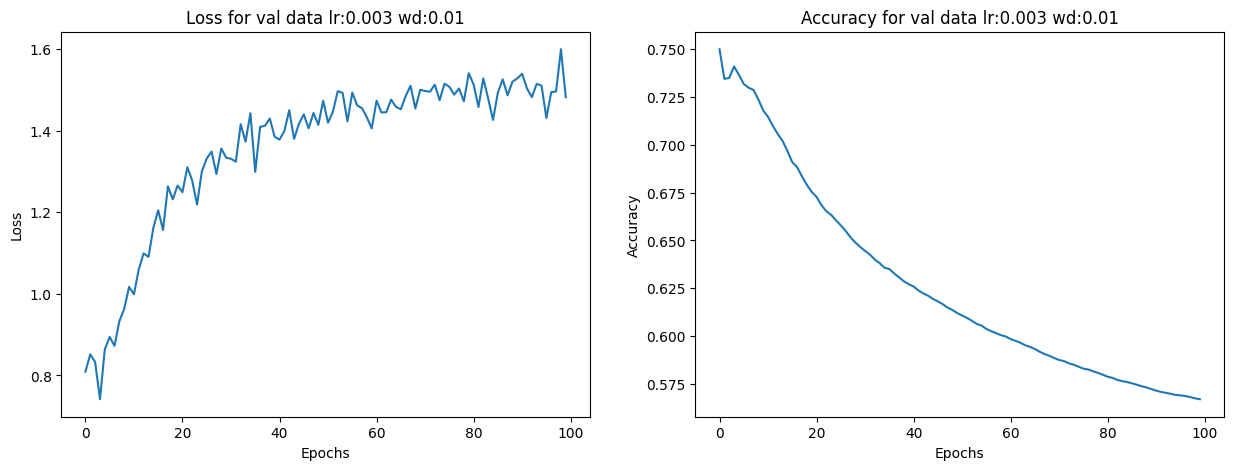

experiment number:  6 out of:  10
learning rate:  0.003 weight decay:  0.001


  0%|          | 0/100000 [00:00<?, ?it/s]

5000 5% (38m 0s) 0.3704 Araujo / Portuguese ✓ 0.7464
iter: 5000 | processed: 5.00% | time: 38m 0s | loss: 0.3704 |  acc: 0.7464
10000 10% (38m 9s) 0.0041 Patrianakos / Greek ✓ 0.7425
iter: 10000 | processed: 10.00% | time: 38m 9s | loss: 0.0041 |  acc: 0.7425
15000 15% (38m 17s) 0.9672 Coupe / French ✓ 0.7396
iter: 15000 | processed: 15.00% | time: 38m 17s | loss: 0.9672 |  acc: 0.7396
20000 20% (38m 26s) 0.2365 Fonseca / Portuguese ✓ 0.7433
iter: 20000 | processed: 20.00% | time: 38m 26s | loss: 0.2365 |  acc: 0.7433
25000 25% (38m 35s) 1.2456 Darby / Arabic ✗ (English) 0.7472
iter: 25000 | processed: 25.00% | time: 38m 35s | loss: 1.2456 |  acc: 0.7472
30000 30% (38m 44s) 0.0689 Mo / Korean ✓ 0.7487
iter: 30000 | processed: 30.00% | time: 38m 44s | loss: 0.0689 |  acc: 0.7487
35000 35% (38m 53s) 0.1916 Hakimi / Arabic ✓ 0.7516
iter: 35000 | processed: 35.00% | time: 38m 53s | loss: 0.1916 |  acc: 0.7516
40000 40% (39m 2s) 0.2972 Kanak / Czech ✓ 0.7523
iter: 40000 | processed: 40.00% 

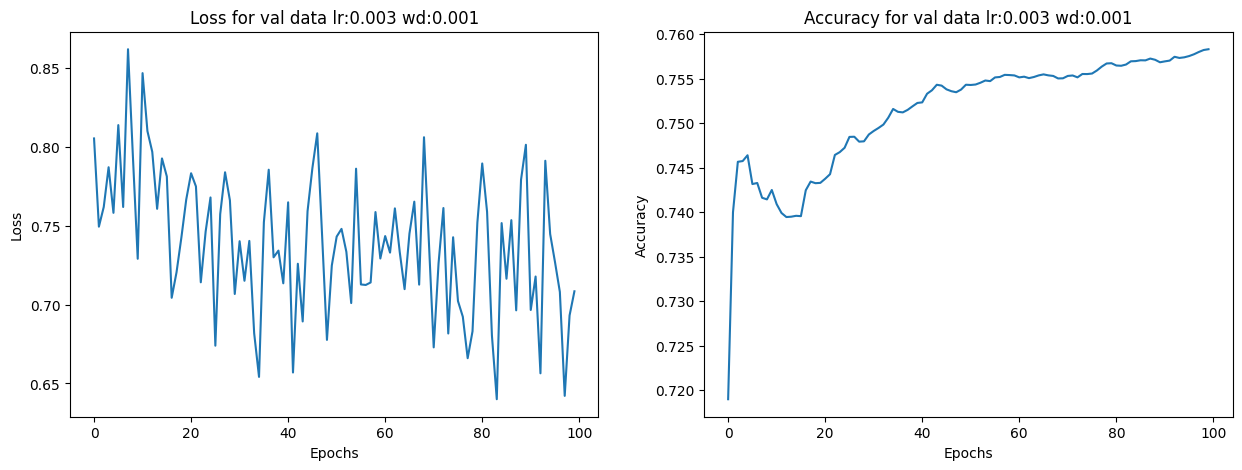

experiment number:  7 out of:  10
learning rate:  0.004 weight decay:  0.01


  0%|          | 0/100000 [00:00<?, ?it/s]

5000 5% (40m 59s) 0.1972 Bahovkin / Russian ✓ 0.7384
iter: 5000 | processed: 5.00% | time: 40m 59s | loss: 0.1972 |  acc: 0.7384
10000 10% (41m 8s) 0.9247 Antwerpen / Dutch ✓ 0.7160
iter: 10000 | processed: 10.00% | time: 41m 8s | loss: 0.9247 |  acc: 0.7160
15000 15% (41m 17s) 0.7417 Van / Vietnamese ✓ 0.6960
iter: 15000 | processed: 15.00% | time: 41m 17s | loss: 0.7417 |  acc: 0.6960
20000 20% (41m 25s) 0.2092 Xue / Chinese ✓ 0.6761
iter: 20000 | processed: 20.00% | time: 41m 25s | loss: 0.2092 |  acc: 0.6761
25000 25% (41m 35s) 1.5955 Tono / Vietnamese ✗ (Japanese) 0.6599
iter: 25000 | processed: 25.00% | time: 41m 35s | loss: 1.5955 |  acc: 0.6599
30000 30% (41m 44s) 0.4935 Choi / Korean ✓ 0.6465
iter: 30000 | processed: 30.00% | time: 41m 44s | loss: 0.4935 |  acc: 0.6465
35000 35% (41m 53s) 0.5342 Ponidelko / Russian ✓ 0.6359
iter: 35000 | processed: 35.00% | time: 41m 53s | loss: 0.5342 |  acc: 0.6359
40000 40% (42m 1s) 1.5045 Odaka / Czech ✗ (Japanese) 0.6267
iter: 40000 | pro

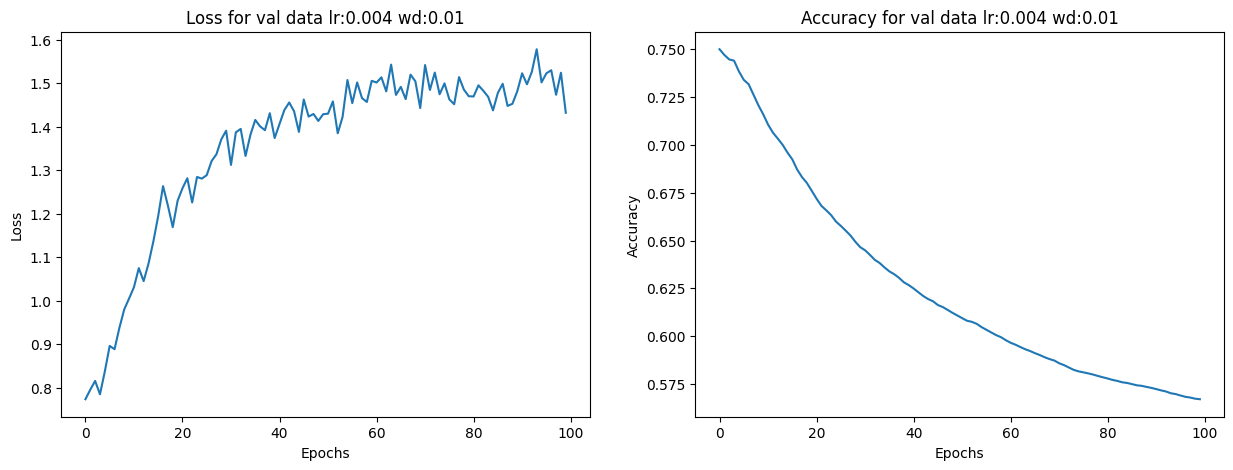

experiment number:  8 out of:  10
learning rate:  0.004 weight decay:  0.001


  0%|          | 0/100000 [00:00<?, ?it/s]

5000 5% (43m 58s) 0.0295 Poirier / French ✓ 0.7322
iter: 5000 | processed: 5.00% | time: 43m 58s | loss: 0.0295 |  acc: 0.7322
10000 10% (44m 6s) 2.4709 Weiman / Russian ✗ (German) 0.7411
iter: 10000 | processed: 10.00% | time: 44m 6s | loss: 2.4709 |  acc: 0.7411
15000 15% (44m 15s) 2.6009 Barros / Portuguese ✗ (Spanish) 0.7426
iter: 15000 | processed: 15.00% | time: 44m 15s | loss: 2.6009 |  acc: 0.7426
20000 20% (44m 24s) 0.6674 Chu / Vietnamese ✓ 0.7486
iter: 20000 | processed: 20.00% | time: 44m 24s | loss: 0.6674 |  acc: 0.7486
25000 25% (44m 33s) 0.2584 Blaise / French ✓ 0.7482
iter: 25000 | processed: 25.00% | time: 44m 33s | loss: 0.2584 |  acc: 0.7482
30000 30% (44m 42s) 3.0104 Attia / Italian ✗ (Arabic) 0.7505
iter: 30000 | processed: 30.00% | time: 44m 42s | loss: 3.0104 |  acc: 0.7505
35000 35% (44m 51s) 2.9266 Forth / Czech ✗ (English) 0.7508
iter: 35000 | processed: 35.00% | time: 44m 51s | loss: 2.9266 |  acc: 0.7508
40000 40% (45m 0s) 0.0164 Bahar / Arabic ✓ 0.7514
ite

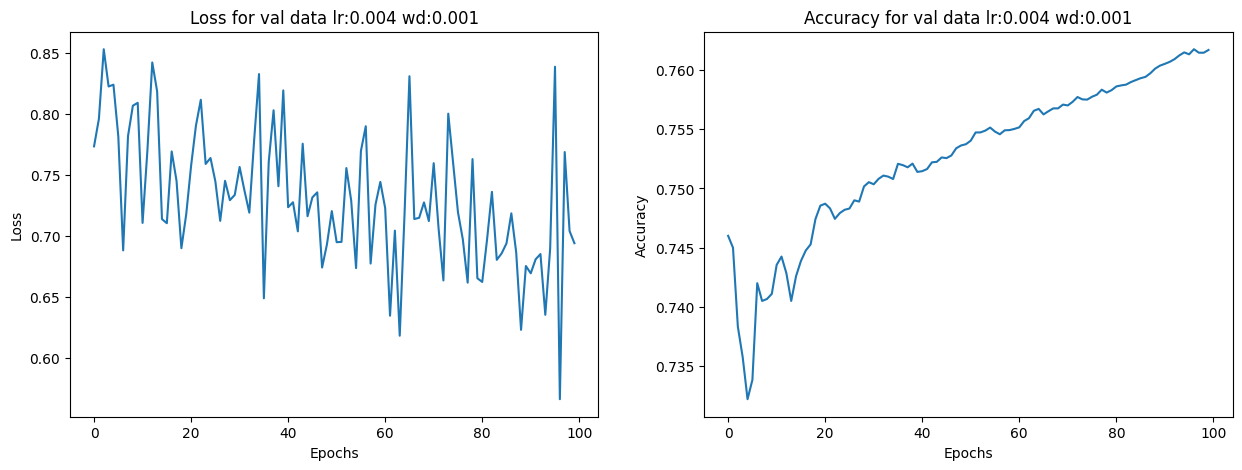

best parameters so far, lr:0.004, wd:0.001
experiment number:  9 out of:  10
learning rate:  0.005 weight decay:  0.01


  0%|          | 0/100000 [00:00<?, ?it/s]

5000 5% (46m 57s) 0.7691 Ha / Vietnamese ✗ (Korean) 0.7352
iter: 5000 | processed: 5.00% | time: 46m 57s | loss: 0.7691 |  acc: 0.7352
10000 10% (47m 6s) 1.3534 Royer / French ✓ 0.7184
iter: 10000 | processed: 10.00% | time: 47m 6s | loss: 1.3534 |  acc: 0.7184
15000 15% (47m 16s) 0.9979 Yuan / Chinese ✓ 0.6964
iter: 15000 | processed: 15.00% | time: 47m 16s | loss: 0.9979 |  acc: 0.6964
20000 20% (47m 25s) 1.1833 Albert / French ✓ 0.6747
iter: 20000 | processed: 20.00% | time: 47m 25s | loss: 1.1833 |  acc: 0.6747
25000 25% (47m 34s) 1.2352 Mar / Chinese ✓ 0.6603
iter: 25000 | processed: 25.00% | time: 47m 34s | loss: 1.2352 |  acc: 0.6603
30000 30% (47m 43s) 2.7981 Ventura / Portuguese ✗ (Italian) 0.6468
iter: 30000 | processed: 30.00% | time: 47m 43s | loss: 2.7981 |  acc: 0.6468
35000 35% (47m 52s) 1.2599 Walker / Scottish ✓ 0.6342
iter: 35000 | processed: 35.00% | time: 47m 52s | loss: 1.2599 |  acc: 0.6342
40000 40% (48m 1s) 2.5317 Martin / Irish ✗ (Scottish) 0.6251
iter: 40000 |

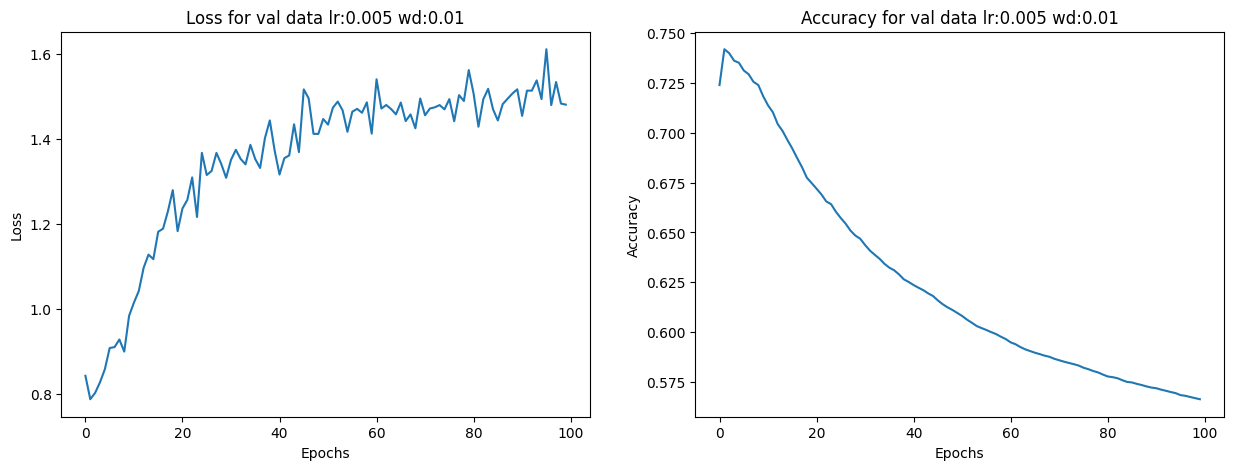

experiment number:  10 out of:  10
learning rate:  0.005 weight decay:  0.001


  0%|          | 0/100000 [00:00<?, ?it/s]

5000 5% (49m 59s) 1.3268 Shamon / Arabic ✓ 0.7182
iter: 5000 | processed: 5.00% | time: 49m 59s | loss: 1.3268 |  acc: 0.7182
10000 10% (50m 8s) 0.4755 Zamorano / Spanish ✓ 0.7338
iter: 10000 | processed: 10.00% | time: 50m 8s | loss: 0.4755 |  acc: 0.7338
15000 15% (50m 18s) 1.2778 Richter / German ✓ 0.7418
iter: 15000 | processed: 15.00% | time: 50m 18s | loss: 1.2778 |  acc: 0.7418
20000 20% (50m 27s) 3.2504 Sala / Spanish ✗ (Italian) 0.7428
iter: 20000 | processed: 20.00% | time: 50m 27s | loss: 3.2504 |  acc: 0.7428
25000 25% (50m 36s) 2.3851 Rosales / Greek ✗ (Spanish) 0.7430
iter: 25000 | processed: 25.00% | time: 50m 36s | loss: 2.3851 |  acc: 0.7430
30000 30% (50m 45s) 0.0578 Calpis / Greek ✓ 0.7450
iter: 30000 | processed: 30.00% | time: 50m 45s | loss: 0.0578 |  acc: 0.7450
35000 35% (50m 54s) 1.0575 Dieter / French ✗ (German) 0.7457
iter: 35000 | processed: 35.00% | time: 50m 54s | loss: 1.0575 |  acc: 0.7457
40000 40% (51m 3s) 0.7664 Ma / Vietnamese ✗ (Korean) 0.7460
iter:

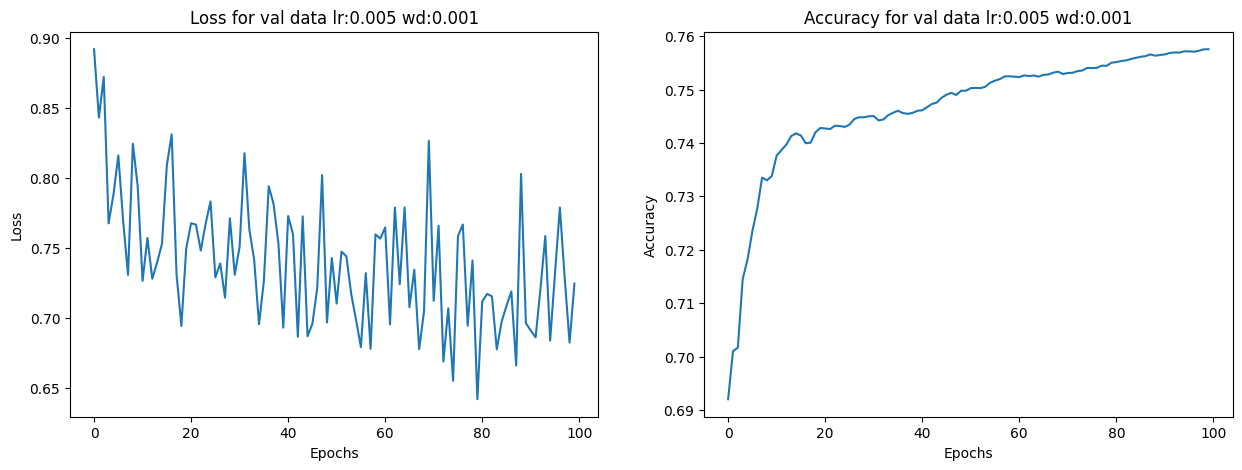

In [ ]:
import copy
cur_acc = accuracy
criterion = nn.NLLLoss()

for parm in parms_comb:
    new_model = RNNExtraLayers(len(ALL_LETTERS), n_hidden, len(CLASSES)).to(device)
    new_model.load_state_dict(copy.deepcopy(rnn_extra_layers.state_dict()))

    print('experiment number: ', parms_comb.index(parm)+1, 'out of: ', len(parms_comb))
    print('learning rate: ', parm[0], 'weight decay: ', parm[1])    
    optimizer = torch.optim.SGD(new_model.parameters(), lr=learning_rate,weight_decay=parm[1])

    all_losses,current_loss,all_acc,accuracy = train_function(model=new_model, data=val_data, n_iters=100000, print_every=5000, plot_every=1000,optimizer=optimizer, criterion=criterion)
    show_plots(all_losses, all_acc,title_1=f'Loss for val data lr:{parm[0]} wd:{parm[1]}',title_2=f'Accuracy for val data lr:{parm[0]} wd:{parm[1]}')
    if accuracy > cur_acc:
        cur_acc = accuracy
        best_lr = parm[0]
        best_wd = parm[1]
        print(f'best parameters so far, lr:{best_lr}, wd:{best_wd}')
        torch.save(new_model.state_dict(), f'best_model_extra_layers_lr_{best_lr}_wd_{best_wd}.pth')

## Loading Best Model

In [ ]:
best_model_name = f'best_model_extra_layers_lr_{best_lr}_wd_{best_wd}.pth'
best_model_extra_layers = RNNExtraLayers(len(ALL_LETTERS), n_hidden, len(CLASSES)).to(device)
best_model_extra_layers.load_state_dict(torch.load(best_model_name))
best_model_extra_layers.eval()

RNNExtraLayers(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o_0): Linear(in_features=185, out_features=185, bias=True)
  (i2o_1): Linear(in_features=185, out_features=185, bias=True)
  (i2o_2): Linear(in_features=185, out_features=185, bias=True)
  (i2o_3): Linear(in_features=185, out_features=18, bias=True)
  (tanh): Tanh()
  (softmax): LogSoftmax(dim=1)
)

## Evaluating Confusion Matrix

/tmp/ipykernel_1353979/464762931.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(CLASSES, rotation=90)
/tmp/ipykernel_1353979/464762931.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(CLASSES)


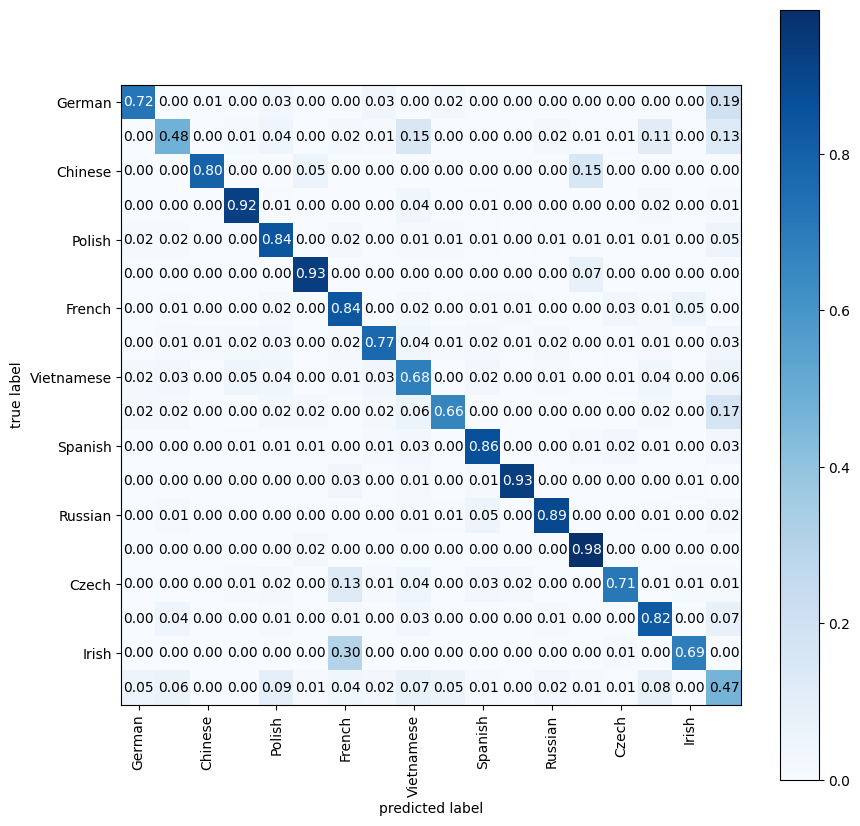

In [ ]:
from mlxtend.plotting import plot_confusion_matrix



# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(len(CLASSES), len(CLASSES))
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = best_model_extra_layers.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = best_model_extra_layers(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample(data=val_data)
    output = evaluate(line_tensor)
    guess, guess_i = lang_from_output(output)
    category_i = CLASSES.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(len(CLASSES)):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig, ax = plot_confusion_matrix(conf_mat=confusion.numpy(),
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True)
# Set up axes
ax.set_xticklabels(CLASSES, rotation=90)
ax.set_yticklabels(CLASSES)

fig.set_size_inches(10, 10)
fig.show()

## Stacked RNN (2 RNN blocks)

In [ ]:
rnn = nn.RNN(10, 128, 1)
input = torch.randn(1, 3, 10)
h0 = torch.randn(1, 3, 128)
output, hn = rnn(input, h0)
output.shape, hn.shape

(torch.Size([1, 3, 128]), torch.Size([1, 3, 128]))

In [ ]:
import torch.nn as nn

# source: https://pytorch.org/docs/stable/generated/torch.nn.RNN.html

class RNNBlocked(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.rnn_block_0 = nn.RNN(input_size , hidden_size)
        self.rnn_block_1 = nn.RNN(hidden_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        h0 = torch.zeros(1, self.hidden_size)
        # combined = torch.cat((input, hidden), 1)
        # print("shapes:", input.shape, hidden.shape, h0.shape)
        output, hidden = self.rnn_block_0(input,hidden)
        # print("shapes:", output.shape, hidden.shape)
        output, hidden = self.rnn_block_1(output, hidden)
        # print("shapes:", output.shape, hidden.shape)
        output = self.linear(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [ ]:
rnn_blocked = RNNBlocked(len(ALL_LETTERS), n_hidden, len(CLASSES)).to(device)

In [ ]:
# training the baseline model
criterion = nn.NLLLoss()
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
optimizer = torch.optim.SGD(rnn_blocked.parameters(), lr=learning_rate)

all_losses, current_loss, all_acc, accuracy = train_function(model=rnn_blocked, data=train_data, n_iters=100000, print_every=5000, plot_every=1000, optimizer=optimizer, criterion=criterion)

  0%|          | 0/100000 [00:00<?, ?it/s]

5000 5% (53m 22s) 2.0145 Luong / Vietnamese ✓ 0.1708
iter: 5000 | processed: 5.00% | time: 53m 22s | loss: 2.0145 |  acc: 0.1708
10000 10% (53m 37s) 1.6871 Haanrath / Dutch ✓ 0.2461
iter: 10000 | processed: 10.00% | time: 53m 37s | loss: 1.6871 |  acc: 0.2461
15000 15% (53m 52s) 2.5870 Kwang  / Dutch ✗ (Korean) 0.2945
iter: 15000 | processed: 15.00% | time: 53m 52s | loss: 2.5870 |  acc: 0.2945
20000 20% (54m 7s) 2.3379 Inao / Portuguese ✗ (Japanese) 0.3237
iter: 20000 | processed: 20.00% | time: 54m 7s | loss: 2.3379 |  acc: 0.3237
25000 25% (54m 23s) 0.7091 Modegi / Japanese ✓ 0.3487
iter: 25000 | processed: 25.00% | time: 54m 23s | loss: 0.7091 |  acc: 0.3487
30000 30% (54m 38s) 0.7361 Coghlan / Irish ✓ 0.3676
iter: 30000 | processed: 30.00% | time: 54m 38s | loss: 0.7361 |  acc: 0.3676
35000 35% (54m 53s) 1.6752 Chu / Korean ✗ (Vietnamese) 0.3853
iter: 35000 | processed: 35.00% | time: 54m 53s | loss: 1.6752 |  acc: 0.3853
40000 40% (55m 8s) 0.1882 Do / Vietnamese ✓ 0.4006
iter: 40

### Loss and Accuracy plot

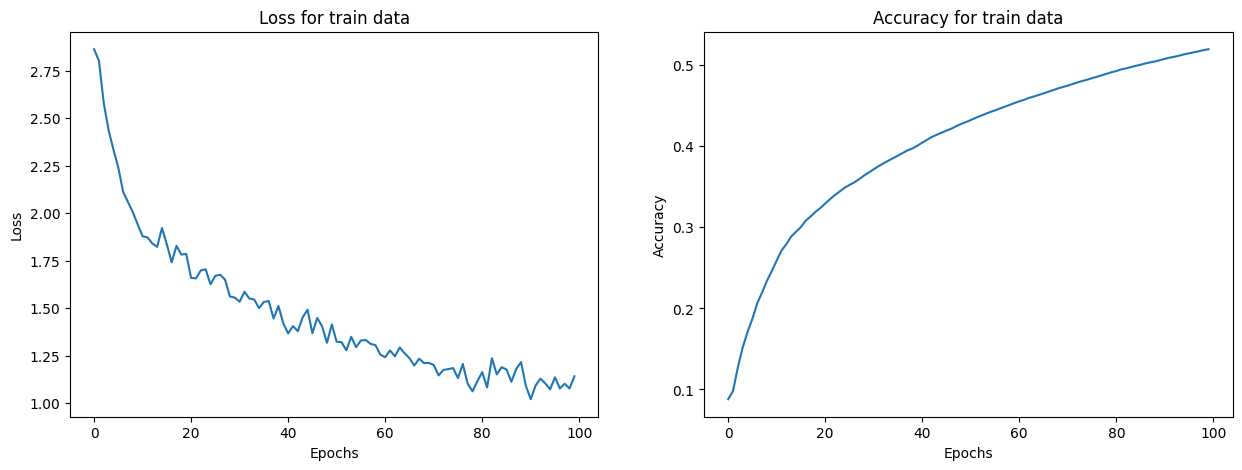

In [ ]:
show_plots(all_losses,all_acc, title_1='Loss for train data',title_2='Accuracy for train data')

In [ ]:
# training the baseline model
criterion = nn.NLLLoss()
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
optimizer = torch.optim.SGD(rnn_blocked.parameters(), lr=learning_rate)

all_losses, current_loss, all_acc, accuracy = train_function(model=rnn_blocked, data=val_data, n_iters=100000, print_every=5000, plot_every=1000, optimizer=optimizer, criterion=criterion)

  0%|          | 0/100000 [00:00<?, ?it/s]

5000 5% (58m 26s) 0.3724 Lachance / French ✓ 0.6580
iter: 5000 | processed: 5.00% | time: 58m 26s | loss: 0.3724 |  acc: 0.6580
10000 10% (58m 41s) 0.6803 Caro / Spanish ✓ 0.6514
iter: 10000 | processed: 10.00% | time: 58m 41s | loss: 0.6803 |  acc: 0.6514
15000 15% (58m 57s) 2.5132 Momotani / Italian ✗ (Japanese) 0.6465
iter: 15000 | processed: 15.00% | time: 58m 57s | loss: 2.5132 |  acc: 0.6465
20000 20% (59m 12s) 1.3907 Acone / French ✗ (Italian) 0.6414
iter: 20000 | processed: 20.00% | time: 59m 12s | loss: 1.3907 |  acc: 0.6414
25000 25% (59m 27s) 0.6917 Kaza / Japanese ✓ 0.6338
iter: 25000 | processed: 25.00% | time: 59m 27s | loss: 0.6917 |  acc: 0.6338
30000 30% (59m 43s) 4.6470 Cho / Chinese ✗ (Korean) 0.6217
iter: 30000 | processed: 30.00% | time: 59m 43s | loss: 4.6470 |  acc: 0.6217
35000 35% (59m 58s) 4.3418 Jordan / Scottish ✗ (French) 0.6009
iter: 35000 | processed: 35.00% | time: 59m 58s | loss: 4.3418 |  acc: 0.6009
40000 40% (60m 13s) 2.6070 Garcia / Japanese ✗ (Span

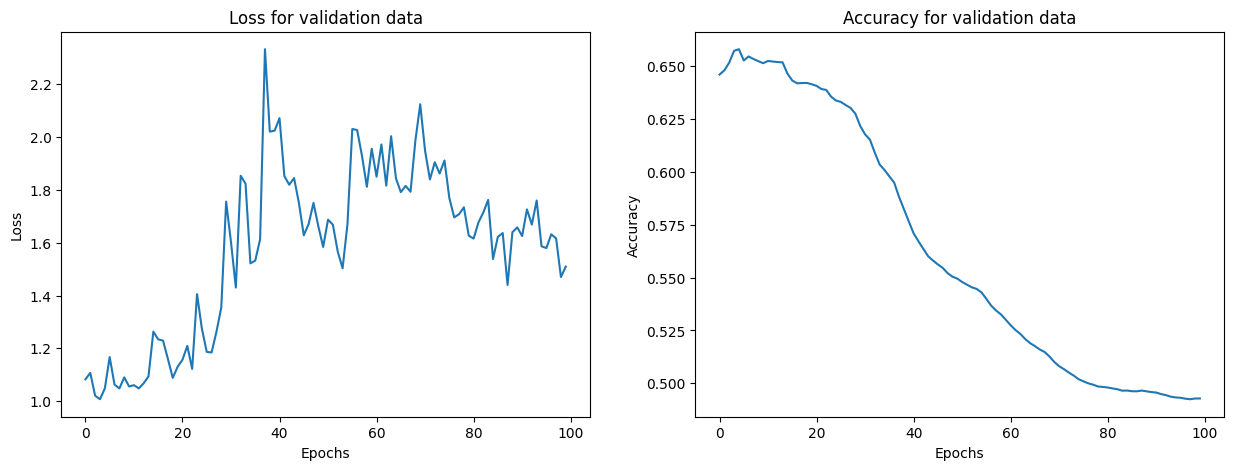

In [ ]:
show_plots(all_losses,all_acc,title_1='Loss for validation data',title_2='Accuracy for validation data')

## Hyperparameter tuning with Val data for Blocks Layer model

In [ ]:
import itertools
# hyperparameters
lr = [0.004, 0.005] # learning rate
weight_decay = [1e-2, 1e-3] # L2 regularization

parms_comb = list(itertools.product(lr, weight_decay))

experiment number:  1 out of:  4
learning rate:  0.004 weight decay:  0.01


  0%|          | 0/100000 [00:00<?, ?it/s]

5000 5% (70m 45s) 0.4770 Hiro / Japanese ✓ 0.5132
iter: 5000 | processed: 5.00% | time: 70m 45s | loss: 0.4770 |  acc: 0.5132
10000 10% (71m 0s) 2.3010 Gell / German ✗ (English) 0.5341
iter: 10000 | processed: 10.00% | time: 71m 0s | loss: 2.3010 |  acc: 0.5341
15000 15% (71m 16s) 1.1804 Zawisza / Polish ✓ 0.5505
iter: 15000 | processed: 15.00% | time: 71m 16s | loss: 1.1804 |  acc: 0.5505
20000 20% (71m 31s) 4.4342 Ruzzier / French ✗ (Italian) 0.5522
iter: 20000 | processed: 20.00% | time: 71m 31s | loss: 4.4342 |  acc: 0.5522
25000 25% (71m 46s) 2.3270 Simoes / Arabic ✗ (Portuguese) 0.5540
iter: 25000 | processed: 25.00% | time: 71m 46s | loss: 2.3270 |  acc: 0.5540
30000 30% (72m 2s) 0.1229 Vuong / Vietnamese ✓ 0.5513
iter: 30000 | processed: 30.00% | time: 72m 2s | loss: 0.1229 |  acc: 0.5513
35000 35% (72m 17s) 2.6657 Michel / English ✗ (French) 0.5479
iter: 35000 | processed: 35.00% | time: 72m 17s | loss: 2.6657 |  acc: 0.5479
40000 40% (72m 33s) 0.3049 Kanesaka / Japanese ✓ 0.5

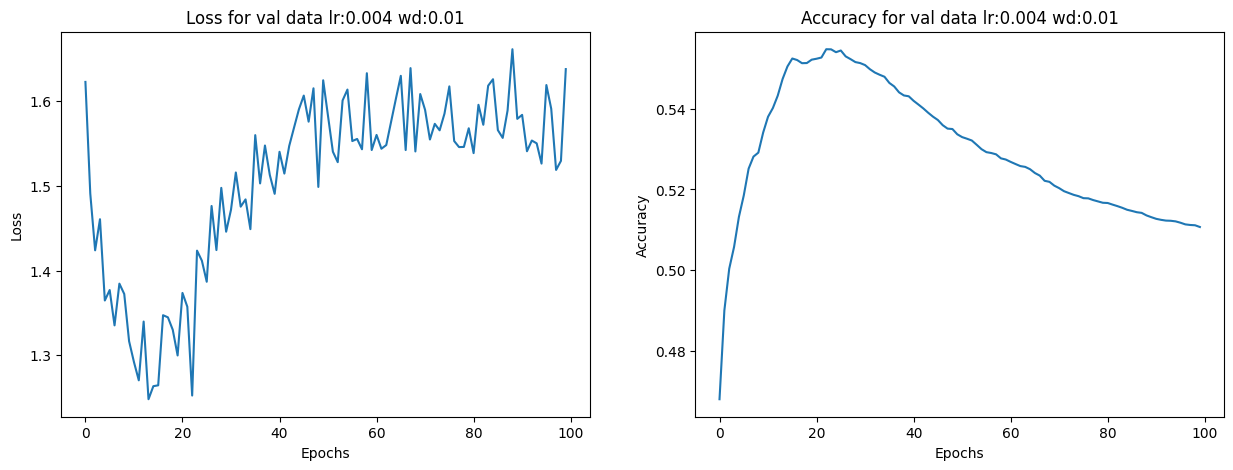

best parameters so far, lr:0.004, wd:0.01
experiment number:  2 out of:  4
learning rate:  0.004 weight decay:  0.001


  0%|          | 0/100000 [00:00<?, ?it/s]

5000 5% (75m 53s) 4.0771 Hughes / Portuguese ✗ (Scottish) 0.4682
iter: 5000 | processed: 5.00% | time: 75m 53s | loss: 4.0771 |  acc: 0.4682
10000 10% (76m 8s) 0.7068 Cui / Chinese ✓ 0.4813
iter: 10000 | processed: 10.00% | time: 76m 8s | loss: 0.7068 |  acc: 0.4813
15000 15% (76m 24s) 1.5164 Moreno / Spanish ✗ (Portuguese) 0.4932
iter: 15000 | processed: 15.00% | time: 76m 24s | loss: 1.5164 |  acc: 0.4932
20000 20% (76m 39s) 1.7078 Lachapelle / Irish ✗ (French) 0.5006
iter: 20000 | processed: 20.00% | time: 76m 39s | loss: 1.7078 |  acc: 0.5006
25000 25% (76m 54s) 2.7072 Demall / Scottish ✗ (Czech) 0.5022
iter: 25000 | processed: 25.00% | time: 76m 54s | loss: 2.7072 |  acc: 0.5022
30000 30% (77m 10s) 1.0985 Masson / French ✓ 0.5091
iter: 30000 | processed: 30.00% | time: 77m 10s | loss: 1.0985 |  acc: 0.5091
35000 35% (77m 25s) 0.1185 Alberici / Italian ✓ 0.5163
iter: 35000 | processed: 35.00% | time: 77m 25s | loss: 0.1185 |  acc: 0.5163
40000 40% (77m 41s) 2.2633 Wojda / Czech ✗ (

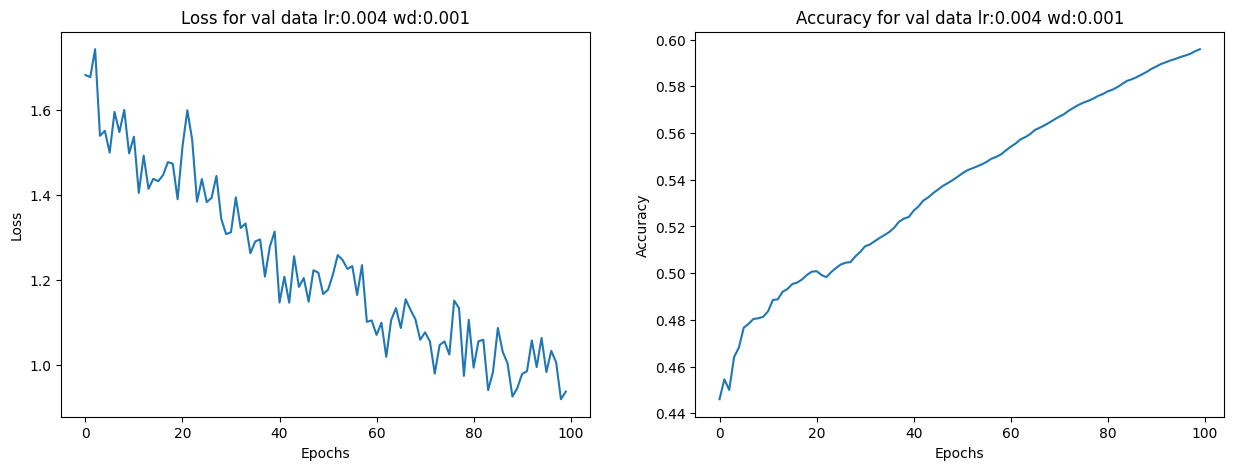

best parameters so far, lr:0.004, wd:0.001
experiment number:  3 out of:  4
learning rate:  0.005 weight decay:  0.01


  0%|          | 0/100000 [00:00<?, ?it/s]

5000 5% (81m 0s) 1.5240 Tahan / Irish ✗ (Arabic) 0.5094
iter: 5000 | processed: 5.00% | time: 81m 0s | loss: 1.5240 |  acc: 0.5094
10000 10% (81m 16s) 0.0752 Xue / Chinese ✓ 0.5332
iter: 10000 | processed: 10.00% | time: 81m 16s | loss: 0.0752 |  acc: 0.5332
15000 15% (81m 31s) 0.2328 Santos / Portuguese ✓ 0.5523
iter: 15000 | processed: 15.00% | time: 81m 31s | loss: 0.2328 |  acc: 0.5523
20000 20% (81m 46s) 0.3672 Kuang / Chinese ✓ 0.5560
iter: 20000 | processed: 20.00% | time: 81m 46s | loss: 0.3672 |  acc: 0.5560
25000 25% (82m 1s) 1.8245 Tobias / Greek ✗ (French) 0.5524
iter: 25000 | processed: 25.00% | time: 82m 1s | loss: 1.8245 |  acc: 0.5524
30000 30% (82m 17s) 5.5717 Rog / Korean ✗ (Polish) 0.5500
iter: 30000 | processed: 30.00% | time: 82m 17s | loss: 5.5717 |  acc: 0.5500
35000 35% (82m 32s) 3.2941 Hughes / Arabic ✗ (Scottish) 0.5431
iter: 35000 | processed: 35.00% | time: 82m 32s | loss: 3.2941 |  acc: 0.5431
40000 40% (82m 48s) 2.1034 Gomulka / Czech ✗ (Polish) 0.5377
ite

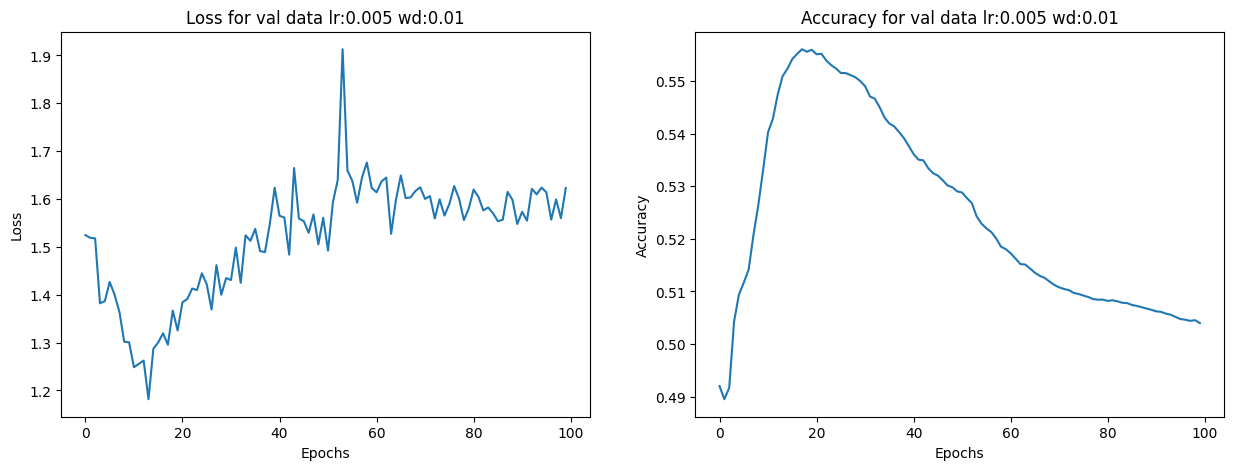

experiment number:  4 out of:  4
learning rate:  0.005 weight decay:  0.001


  0%|          | 0/100000 [00:00<?, ?it/s]

5000 5% (86m 7s) 2.4827 Poirier / Dutch ✗ (French) 0.4612
iter: 5000 | processed: 5.00% | time: 86m 7s | loss: 2.4827 |  acc: 0.4612
10000 10% (86m 23s) 1.5728 Simoes / Portuguese ✓ 0.4441
iter: 10000 | processed: 10.00% | time: 86m 23s | loss: 1.5728 |  acc: 0.4441
15000 15% (86m 38s) 1.0602 Rudaski / Japanese ✗ (Polish) 0.4201
iter: 15000 | processed: 15.00% | time: 86m 38s | loss: 1.0602 |  acc: 0.4201
20000 20% (86m 54s) 0.2146 Thach / Vietnamese ✓ 0.4266
iter: 20000 | processed: 20.00% | time: 86m 54s | loss: 0.2146 |  acc: 0.4266
25000 25% (87m 9s) 0.2832 Kikui / Japanese ✓ 0.4390
iter: 25000 | processed: 25.00% | time: 87m 9s | loss: 0.2832 |  acc: 0.4390
30000 30% (87m 24s) 2.5733 Araullo / Italian ✗ (Portuguese) 0.4514
iter: 30000 | processed: 30.00% | time: 87m 24s | loss: 2.5733 |  acc: 0.4514
35000 35% (87m 40s) 2.5101 Robb / Arabic ✗ (English) 0.4643
iter: 35000 | processed: 35.00% | time: 87m 40s | loss: 2.5101 |  acc: 0.4643
40000 40% (87m 55s) 2.9478 Tahan / Vietnamese 

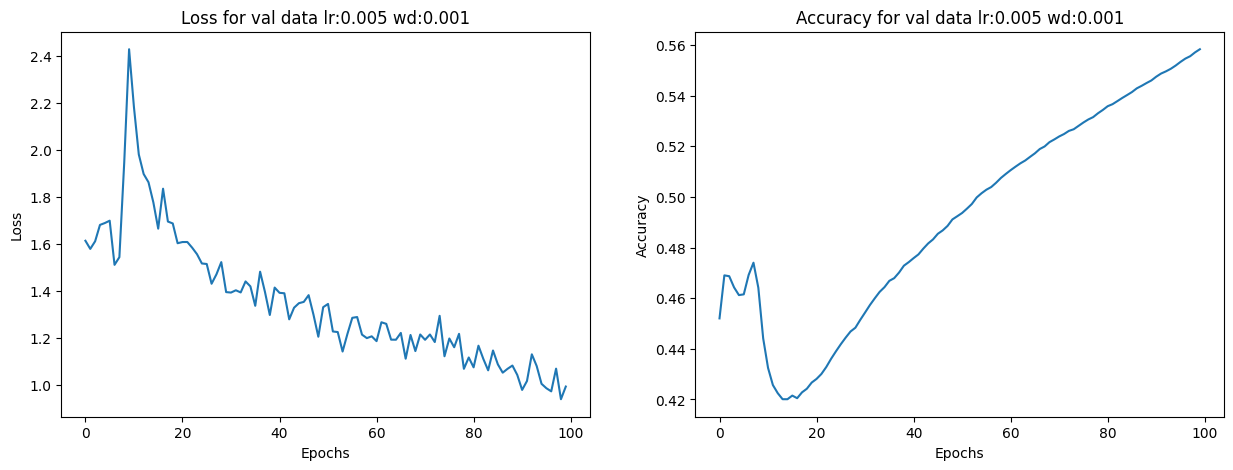

In [ ]:
import copy
cur_acc = accuracy
criterion = nn.NLLLoss()

for parm in parms_comb:
    new_model = RNNBlocked(len(ALL_LETTERS), n_hidden, len(CLASSES)).to(device)
    new_model.load_state_dict(copy.deepcopy(rnn_blocked.state_dict()))

    print('experiment number: ', parms_comb.index(parm)+1, 'out of: ', len(parms_comb))
    print('learning rate: ', parm[0], 'weight decay: ', parm[1])    
    optimizer = torch.optim.SGD(new_model.parameters(), lr=learning_rate,weight_decay=parm[1])

    all_losses,current_loss,all_acc,accuracy = train_function(model=new_model, data=val_data, n_iters=100000, print_every=5000, plot_every=1000,optimizer=optimizer, criterion=criterion)
    show_plots(all_losses, all_acc,title_1=f'Loss for val data lr:{parm[0]} wd:{parm[1]}',title_2=f'Accuracy for val data lr:{parm[0]} wd:{parm[1]}')
    if accuracy > cur_acc:
        cur_acc = accuracy
        best_lr = parm[0]
        best_wd = parm[1]
        print(f'best parameters so far, lr:{best_lr}, wd:{best_wd}')
        torch.save(new_model.state_dict(), f'best_model_blocked_layers_lr_{best_lr}_wd_{best_wd}.pth')

## Loading Best Model

In [ ]:
best_model_name = f'best_model_blocked_layers_lr_{best_lr}_wd_{best_wd}.pth'
best_model_blocked = RNNBlocked(len(ALL_LETTERS), n_hidden, len(CLASSES)).to(device)
best_model_blocked.load_state_dict(torch.load(best_model_name))
best_model_blocked.eval()

RNNBlocked(
  (rnn_block_0): RNN(57, 128)
  (rnn_block_1): RNN(128, 128)
  (linear): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)

## Evaluating Confusion Matrix

/tmp/ipykernel_1353979/2615066782.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(CLASSES, rotation=90)
/tmp/ipykernel_1353979/2615066782.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(CLASSES)


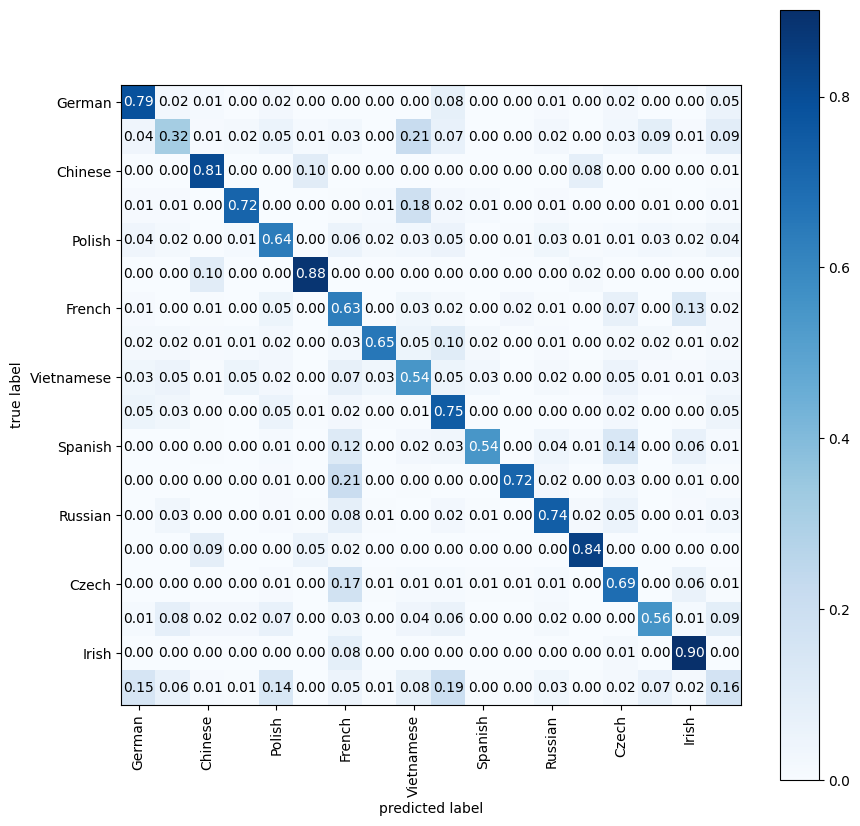

In [ ]:
from mlxtend.plotting import plot_confusion_matrix


# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(len(CLASSES), len(CLASSES))
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = best_model_extra_layers.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = best_model_extra_layers(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample(data=val_data)
    output = evaluate(line_tensor)
    guess, guess_i = lang_from_output(output)
    category_i = CLASSES.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(len(CLASSES)):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig, ax = plot_confusion_matrix(conf_mat=confusion.numpy(),
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True)
# Set up axes
ax.set_xticklabels(CLASSES, rotation=90)
ax.set_yticklabels(CLASSES)

fig.set_size_inches(10, 10)
fig.show()

## Inference

### fucntion for infrerence

In [ ]:
def infrerence(model:nn.Module, line:str):
    '''
    desc: function to infer the language of a given name
    args:
        model (nn.Module): the model to use for inference
        line (str): the name to infer the language
    returns:
        the language of the name
    '''
    input = line_to_tensor(line).to(device)
    hidden = torch.zeros(1, n_hidden).to(device)

    output, next_hidden = model(input[0], hidden)
    return lang_from_output(output)[0]

In [ ]:
names = "Emilia, Alexandra, Sachiko, Vladimir, Minh, Xi, Muammar, Mukesh, Andrew, Ronaldo"
names_list = names.split(', ')

for name in names_list:
    print(f"name: {name}, language: {infrerence(best_model_blocked, name)}")

name: Emilia, language: Vietnamese
name: Alexandra, language: Vietnamese
name: Sachiko, language: Japanese
name: Vladimir, language: Dutch
name: Minh, language: Vietnamese
name: Xi, language: Russian
name: Muammar, language: Vietnamese
name: Mukesh, language: Vietnamese
name: Andrew, language: Vietnamese
name: Ronaldo, language: Italian
